# Preparing summary statistics (SumStats) of the GWAS on age-of-onset ischemic stroke for GWAS Catalog

This notebook serves to inspect `AAO GWAS SumStats`, and proceses the _discovery_ meta-analysis GWAS data for sharing through *GWAS Catalog*.

Populations: 
- `gwas_combo` = Combined sexes, European population, `discovery_group/21.04.12.alleur.groupcov.stats.gz`
- `gwas_women` = Women-only data, European population, `discovery_xx.group/21.04.13.xx.eur.groupcov.stats.gz`
- `gwas_men` = Men-only, European population, `discovery_xy.group/21.04.13.xy.eur.groupcov.stats.gz`


## Check for anomalous alleles

It turns out we have variants that have alleles coded as _DEL_ and as _TT*N_. These two are not resolvable and unacceptable for deposit in repositories or downstream analytical programs. We filtered these through these `baash` commands. 

```
$ gzcat discovery_xy.group/21.04.13.xy.eur.groupcov.stats.gz | grep "<" | head
esv2668971	1	17676773	0	C	<DEL>	0.651017	0.7855	-0.151376	0.25115	5.5E-01
esv2677880	1	25591101	0	G	<DEL>	0.593077	0.923229	0.0483997	0.226888	8.3E-01
esv2656832	1	25591901	0	G	<DEL>	0.593591	0.922586	0.0500368	0.227043	8.3E-01
esv2657070	1	25614201	0	G	<DEL>	0.611186	0.835544	0.105669	0.241737	6.6E-01
esv2660377	1	26459901	0	C	<DEL>	0.835867	0.997442	0.0309001	0.290807	9.2E-01
esv2657809	1	62115151	0	T	<DEL>	0.853304	0.927741	0.219319	0.313322	4.8E-01
esv2665550	1	108732201	0	C	<DEL>	0.945779	0.656023	0.0765448	0.580506	9.0E-01
esv2676246	1	110223001	0	G	<DEL>	0.283962	0.760732	0.313287	0.273316	2.5E-01
esv2669133	1	112691801	0	G	<DEL>	0.680302	0.911305	-0.149431	0.244641	5.4E-01
esv2674493	1	169225801	0	T	<DEL>	0.623863	0.991748	-0.147698	0.222684	5.1E-01

$ gzcat discovery_xy.group/21.04.13.xy.eur.groupcov.stats.gz | grep "N" | head
SNP	CHR	BP	GENPOS	ALLELE1	ALLELE0	A1FREQ	INFO	BETA	SE	P_BOLT_LMM_INF
rs143418322	11	22819068	0	T	TTCN	0.850445	0.981047	-0.391315	0.303895	2.0E-01
rs201380680	11	118373030	0	T	TAN	0.932981	0.876645	0.326323	0.453315	4.7E-01
14-58419899	14	58419899	0	T	TTATN	0.850263	0.94382	-0.31709	0.308973	3.0E-01
rs200456769	18	78014202	0	TTN	T	0.474066	0.9564	0.232862	0.219385	2.9E-01

$ gzcat discovery_group/21.04.12.alleur.groupcov.stats.gz | head -1 > discovery_group/21.04.12.alleur.groupcov.stats.noDEL_TTN.txt
$ gzcat discovery_xx.group/21.04.13.xx.eur.groupcov.stats.gz | head -1 > discovery_xx.group/21.04.13.xx.eur.groupcov.stats.noDEL_TTN.txt
$ gzcat discovery_xy.group/21.04.13.xy.eur.groupcov.stats.gz | head -1 > discovery_xy.group/21.04.13.xy.eur.groupcov.stats.noDEL_TTN.txt

$ gzcat discovery_group/21.04.12.alleur.groupcov.stats.gz | grep -v "N" | grep -v "<" >> discovery_group/21.04.12.alleur.groupcov.stats.noDEL_TTN.txt
$ gzcat discovery_xx.group/21.04.13.xx.eur.groupcov.stats.gz | grep -v "N" | grep -v "<" >> discovery_xx.group/21.04.13.xx.eur.groupcov.stats.noDEL_TTN.txt
$ gzcat discovery_xy.group/21.04.13.xy.eur.groupcov.stats.gz | grep -v "N" | grep -v "<" >> discovery_xy.group/21.04.13.xy.eur.groupcov.stats.noDEL_TTN.txt

$ gzip -v discovery_group/21.04.12.alleur.groupcov.stats.noDEL_TTN.txt
$ gzip -v discovery_xx.group/21.04.13.xx.eur.groupcov.stats.noDEL_TTN.txt
$ gzip -v discovery_xy.group/21.04.13.xy.eur.groupcov.stats.noDEL_TTN.txt

```

## Import necessary libraries

In [14]:
# Function to check for installation of required packages
def check_install_package(package_name):
    try:
        importlib.import_module(package_name)
    except ImportError:
        print(f'{package_name} is not installed. Installing it now...')
        subprocess.check_call(['pip', 'install', package_name])

import os
import glob
import importlib
import subprocess
import sys

# argument parsing
import argparse

# get date and time
from datetime import datetime

# Pandas is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool
check_install_package('pandas')
import pandas as pd

# pyarrow is supperior to loading parquet files
check_install_package('pyarrow')
import pyarrow as pa
import pyarrow.parquet as pq

# polars is a fast dataframe library
check_install_package('polars')
import polars as pl

# for statistical analysis
check_install_package('scipy')
from scipy import stats
import numpy as np

# scientific colourmaps
# https://www.fabiocrameri.ch/ws/media-library/8c4b111121ff448e843dfef9220bf613/readme_scientificcolourmaps.pdf
check_install_package('cmcrameri')
import cmcrameri as ccm
from cmcrameri import cm

# for plotting
check_install_package('matplotlib')
import matplotlib
import matplotlib.pyplot as plt
# if using a Jupyter notebook, include:
%matplotlib inline

# use Seaborn for visualisations
check_install_package('seaborn')
import seaborn as sns

# for handling GWAS data
import gwaslab as gl

Creating directories for plots

In [15]:
# Create directories for the GWAS data and the reference data
import os
from subprocess import check_output

# general plotting directory
PLOTS_loc = "AAO/PLOTS"

# Reference data directory
REF_loc = "/Users/slaan3/PLINK/references"
print("Checking contents of the reference directory:")
print(check_output(["ls", os.path.join(REF_loc)]).decode("utf8"))

# GWAS data directory
GWAS_RES_loc = "/Users/slaan3/PLINK/_GWAS_Datasets/_SiGN"
print("Checking contents of the GWAS data directory:")
print(check_output(["ls", os.path.join(GWAS_RES_loc)]).decode("utf8"))

# Check if the directory exists
if not os.path.exists(os.path.join(GWAS_RES_loc, "GWASCatalog")):
    # If it doesn't exist, create it
    os.makedirs(os.path.join(GWAS_RES_loc, "GWASCatalog"))

# GWAS Catalog directory
GWASCatalog_loc = os.path.join(GWAS_RES_loc, "GWASCatalog")

Checking contents of the reference directory:
1000G
HRC_r1_1_2016
HRCr11_1000Gp3v5
dbSNP
tcga

Checking contents of the GWAS data directory:
AOO_MEN_b37.gwaslab.ssf.ssf.log
AOO_MEN_b37.gwaslab.ssf.ssf.tsv.gz
GWASCatalog
discovery_group
discovery_xx.group
discovery_xy.group



## Loading data

Loading the different datasets.

In [16]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output

# print(check_output(["ls", os.path.join(GWAS_RES_loc, "/meta_discovery/discovery_group/")]).decode("utf8"))

print(
    check_output(
        ["ls", os.path.join(GWAS_RES_loc, "discovery_group")]).decode("utf8")
)
print(
    check_output(["ls", os.path.join(GWAS_RES_loc, "discovery_xx.group")]).decode(
        "utf8"
    )
)
print(
    check_output(["ls", os.path.join(GWAS_RES_loc, "discovery_xy.group")]).decode(
        "utf8"
    )
)

21.04.12.alleur.groupcov.stats.gz
21.04.12.alleur.groupcov.stats.noDEL_TTN.txt.gz
AOO_COMBINED_b37.gwaslab.log
AOO_COMBINED_b37.gwaslab.parquet
AOO_COMBINED_b37.gwaslab.pkl

21.04.13.xx.eur.groupcov.stats.gz
21.04.13.xx.eur.groupcov.stats.noDEL_TTN.txt.gz
AOO_WOMEN_b37.gwaslab.log
AOO_WOMEN_b37.gwaslab.parquet
AOO_WOMEN_b37.gwaslab.pkl

21.04.13.xy.eur.groupcov.stats.gz
21.04.13.xy.eur.groupcov.stats.noDEL_TTN.txt.gz
AOO_MEN_b37.gwaslab.log
AOO_MEN_b37.gwaslab.parquet
AOO_MEN_b37.gwaslab.pkl



### Combined data

The general format of the data is as follows:

```
SNP	CHR	BP	GENPOS	ALLELE1	ALLELE0	A1FREQ	INFO	BETA	SE	P_BOLT_LMM_INF
rs58108140	1	10583	0	G	A	0.850249	0.301118	-0.658801	0.423637	1.2E-01
rs180734498	1	13302	0	C	T	0.906641	0.332755	-0.139703	0.509556	7.8E-01
rs140337953	1	30923	0	G	T	0.165905	0.330267	0.317905	0.40355	4.3E-01
rs116400033	1	51479	0	T	A	0.819279	0.318227	-0.199339	0.383897	6.0E-01
```


In [17]:
# read in data
# https://stackoverflow.com/questions/33813815/how-to-read-a-parquet-file-into-pandas-dataframe

import polars as pl

temp = pl.read_csv(
    source=os.path.join(
        GWAS_RES_loc, "discovery_group/21.04.12.alleur.groupcov.stats.noDEL_TTN.txt.gz"
    ),
    has_header=True,
    separator="\t",
    ignore_errors=False,
    # n_rows=1000, # for debugging
    quote_char=None,
    # necessary to fix issues with missing values when reading data
    null_values=["NA"],
)
# change polars dataframe to pandas dataframe
gwas_combo = temp.to_pandas()

### Women-only

The general format of the data is as follows:

```
SNP	CHR	BP	GENPOS	ALLELE1	ALLELE0	A1FREQ	INFO	BETA	SE	P_BOLT_LMM_INF
rs58108140	1	10583	0	G	A	0.848383	0.301118	-0.824988	0.659326	2.1E-01
rs180734498	1	13302	0	C	T	0.907042	0.332755	-0.659718	0.806601	4.1E-01
rs140337953	1	30923	0	G	T	0.166339	0.330267	0.782017	0.644221	2.2E-01
rs116400033	1	51479	0	T	A	0.816609	0.318227	-0.173976	0.602009	7.7E-01
```


In [18]:
# read in data
# https://stackoverflow.com/questions/33813815/how-to-read-a-parquet-file-into-pandas-dataframe

import polars as pl

temp = pl.read_csv(
    source=os.path.join(
        GWAS_RES_loc,
        "discovery_xx.group/21.04.13.xx.eur.groupcov.stats.noDEL_TTN.txt.gz",
    ),
    has_header=True,
    separator="\t",
    ignore_errors=False,
    # n_rows=1000, # for debugging
    quote_char=None,
    # necessary to fix issues with missing values when reading data
    null_values=["NA"],
)
# change polars dataframe to pandas dataframe
gwas_women = temp.to_pandas()

### Men-only

The general format of the data is as follows:

```
SNP	CHR	BP	GENPOS	ALLELE1	ALLELE0	A1FREQ	INFO	BETA	SE	P_BOLT_LMM_INF
rs58108140	1	10583	0	G	A	0.851716	0.301118	-0.519809	0.549089	3.4E-01
rs180734498	1	13302	0	C	T	0.906325	0.332755	0.271376	0.651686	6.8E-01
rs140337953	1	30923	0	G	T	0.165563	0.330267	-0.0024671	0.513017	1.0E+00
rs116400033	1	51479	0	T	A	0.821378	0.318227	-0.265338	0.494794	5.9E-01
```


In [19]:
# read in data
# https://stackoverflow.com/questions/33813815/how-to-read-a-parquet-file-into-pandas-dataframe

import polars as pl

temp = pl.read_csv(
    source=os.path.join(
        GWAS_RES_loc,
        "discovery_xy.group/21.04.13.xy.eur.groupcov.stats.noDEL_TTN.txt.gz",
    ),
    has_header=True,
    separator="\t",
    ignore_errors=False,
    # n_rows=1000, # for debugging
    quote_char=None,
    # necessary to fix issues with missing values when reading data
    null_values=["NA"],
)
# change polars dataframe to pandas dataframe
gwas_men = temp.to_pandas()

### Inspection of data

Here we do a quick check on what is what in the data.

Let's inspect what is what.

Printing head of combined data:

In [20]:
gwas_combo.head()

,SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,INFO,BETA,SE,P_BOLT_LMM_INF
0,rs58108140,1,10583,0,G,A,0.850249,0.301118,-0.658801,0.423637,0.12
1,rs180734498,1,13302,0,C,T,0.906641,0.332755,-0.139703,0.509556,0.78
2,rs140337953,1,30923,0,G,T,0.165905,0.330267,0.317905,0.403550,0.43
3,rs116400033,1,51479,0,T,A,0.819279,0.318227,-0.199339,0.383897,0.60
4,rs141149254,1,54490,0,G,A,0.823351,0.322577,-0.035508,0.383277,0.93


Printing head of Women-only data:

In [21]:
gwas_women.head()

,SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,INFO,BETA,SE,P_BOLT_LMM_INF
0,rs58108140,1,10583,0,G,A,0.848383,0.301118,-0.824988,0.659326,0.21
1,rs180734498,1,13302,0,C,T,0.907042,0.332755,-0.659718,0.806601,0.41
2,rs140337953,1,30923,0,G,T,0.166339,0.330267,0.782017,0.644221,0.22
3,rs116400033,1,51479,0,T,A,0.816609,0.318227,-0.173976,0.602009,0.77
4,rs141149254,1,54490,0,G,A,0.820977,0.322577,0.308928,0.603387,0.61


Printing head of Men-only data

In [22]:
gwas_men.head()

,SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,INFO,BETA,SE,P_BOLT_LMM_INF
0,rs58108140,1,10583,0,G,A,0.851716,0.301118,-0.519809,0.549089,0.34
1,rs180734498,1,13302,0,C,T,0.906325,0.332755,0.271376,0.651686,0.68
2,rs140337953,1,30923,0,G,T,0.165563,0.330267,-0.002467,0.513017,1.00
3,rs116400033,1,51479,0,T,A,0.821378,0.318227,-0.265338,0.494794,0.59
4,rs141149254,1,54490,0,G,A,0.825216,0.322577,-0.371793,0.492553,0.45


In [23]:
print("Printing shape of combined data:\n", gwas_combo.shape)

Printing shape of combined data:
 (6750263, 11)


In [24]:
print("Printing shape of Women-only data:\n", gwas_women.shape)

Printing shape of Women-only data:
 (6750263, 11)


In [25]:
print("Printing shape of Men-only data:\n", gwas_men.shape)

Printing shape of Men-only data:
 (6750263, 11)


In [26]:
print("Printing columns of combined data:\n", gwas_combo.columns)

Printing columns of combined data:
 Index(['SNP', 'CHR', 'BP', 'GENPOS', 'ALLELE1', 'ALLELE0', 'A1FREQ', 'INFO',
       'BETA', 'SE', 'P_BOLT_LMM_INF'],
      dtype='object')


In [27]:
print("Printing columns of Women-only data:\n", gwas_women.columns)

Printing columns of Women-only data:
 Index(['SNP', 'CHR', 'BP', 'GENPOS', 'ALLELE1', 'ALLELE0', 'A1FREQ', 'INFO',
       'BETA', 'SE', 'P_BOLT_LMM_INF'],
      dtype='object')


In [28]:
print("Printing columns of Men-only data:\n", gwas_men.columns)

Printing columns of Men-only data:
 Index(['SNP', 'CHR', 'BP', 'GENPOS', 'ALLELE1', 'ALLELE0', 'A1FREQ', 'INFO',
       'BETA', 'SE', 'P_BOLT_LMM_INF'],
      dtype='object')


In [29]:
print("Printing info of combined data:\n", gwas_combo.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6750263 entries, 0 to 6750262
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   SNP             object 
 1   CHR             int64  
 2   BP              int64  
 3   GENPOS          int64  
 4   ALLELE1         object 
 5   ALLELE0         object 
 6   A1FREQ          float64
 7   INFO            float64
 8   BETA            float64
 9   SE              float64
 10  P_BOLT_LMM_INF  float64
dtypes: float64(5), int64(3), object(3)
memory usage: 566.5+ MB
Printing info of combined data:
 None


In [30]:
print("Printing info of Women-only data:\n", gwas_women.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6750263 entries, 0 to 6750262
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   SNP             object 
 1   CHR             int64  
 2   BP              int64  
 3   GENPOS          int64  
 4   ALLELE1         object 
 5   ALLELE0         object 
 6   A1FREQ          float64
 7   INFO            float64
 8   BETA            float64
 9   SE              float64
 10  P_BOLT_LMM_INF  float64
dtypes: float64(5), int64(3), object(3)
memory usage: 566.5+ MB
Printing info of Women-only data:
 None


In [31]:
print("Printing info of Men-only data:\n", gwas_men.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6750263 entries, 0 to 6750262
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   SNP             object 
 1   CHR             int64  
 2   BP              int64  
 3   GENPOS          int64  
 4   ALLELE1         object 
 5   ALLELE0         object 
 6   A1FREQ          float64
 7   INFO            float64
 8   BETA            float64
 9   SE              float64
 10  P_BOLT_LMM_INF  float64
dtypes: float64(5), int64(3), object(3)
memory usage: 566.5+ MB
Printing info of Men-only data:
 None


Getting some per column summary statistics.

In [32]:
print("Printing describe of combined data:\n", gwas_combo.describe())

Printing describe of combined data:
                 CHR            BP     GENPOS        A1FREQ          INFO  \
count  6.750263e+06  6.750263e+06  6750263.0  6.750263e+06  6.750263e+06   
mean   8.697022e+00  7.832229e+07        0.0  6.689734e-01  9.668220e-01   
std    5.774145e+00  5.663508e+07        0.0  2.494505e-01  7.043201e-02   
min    1.000000e+00  3.020000e+02        0.0  1.794340e-03  2.183440e-02   
25%    4.000000e+00  3.168946e+07        0.0  5.018640e-01  9.728170e-01   
50%    8.000000e+00  6.859110e+07        0.0  7.439010e-01  9.918490e-01   
75%    1.300000e+01  1.142337e+08        0.0  8.811840e-01  9.971240e-01   
max    2.200000e+01  2.492328e+08        0.0  9.990260e-01  1.000000e+00   

               BETA            SE  P_BOLT_LMM_INF  
count  6.750263e+06  6.750263e+06    6.750263e+06  
mean  -6.483778e-04  2.369407e-01    4.940284e-01  
std    2.532999e-01  7.800336e-02    2.908264e-01  
min   -4.723600e+00  1.639520e-01    7.000000e-07  
25%   -1.536275e-0

In [33]:
print("Printing describe of Women-only data:\n", gwas_women.describe())

Printing describe of Women-only data:
                 CHR            BP     GENPOS        A1FREQ          INFO  \
count  6.750263e+06  6.750263e+06  6750263.0  6.750263e+06  6.750263e+06   
mean   8.697022e+00  7.832229e+07        0.0  6.689662e-01  9.668220e-01   
std    5.774145e+00  5.663508e+07        0.0  2.494700e-01  7.043201e-02   
min    1.000000e+00  3.020000e+02        0.0  1.161070e-03  2.183440e-02   
25%    4.000000e+00  3.168946e+07        0.0  5.019460e-01  9.728170e-01   
50%    8.000000e+00  6.859110e+07        0.0  7.438440e-01  9.918490e-01   
75%    1.300000e+01  1.142337e+08        0.0  8.812000e-01  9.971240e-01   
max    2.200000e+01  2.492328e+08        0.0  9.991110e-01  1.000000e+00   

               BETA            SE  P_BOLT_LMM_INF  
count  6.750263e+06  6.750263e+06    6.750263e+06  
mean  -1.582467e-04  3.738470e-01    4.935410e-01  
std    3.988856e-01  1.233700e-01    2.891631e-01  
min   -8.927970e+00  2.563900e-01    9.300000e-07  
25%   -2.427890e

In [34]:
print("Printing describe of Men-only data:\n", gwas_men.describe())

Printing describe of Men-only data:
                 CHR            BP     GENPOS        A1FREQ          INFO  \
count  6.750263e+06  6.750263e+06  6750263.0  6.750263e+06  6.750263e+06   
mean   8.697022e+00  7.832229e+07        0.0  6.689790e-01  9.668220e-01   
std    5.774145e+00  5.663508e+07        0.0  2.494584e-01  7.043201e-02   
min    1.000000e+00  3.020000e+02        0.0  1.832750e-03  2.183440e-02   
25%    4.000000e+00  3.168946e+07        0.0  5.018340e-01  9.728170e-01   
50%    8.000000e+00  6.859110e+07        0.0  7.438510e-01  9.918490e-01   
75%    1.300000e+01  1.142337e+08        0.0  8.811620e-01  9.971240e-01   
max    2.200000e+01  2.492328e+08        0.0  9.992090e-01  1.000000e+00   

               BETA            SE  P_BOLT_LMM_INF  
count  6.750263e+06  6.750263e+06    6.750263e+06  
mean  -1.550811e-03  3.037693e-01    4.966501e-01  
std    3.225175e-01  1.000948e-01    2.896907e-01  
min   -5.716510e+00  2.083970e-01    3.700000e-08  
25%   -1.957720e-0

### Basic visualisations

Here we plot histograms of allele frequencies, effect, and sample size .

#### Sampling from the data
Here we provide an example on how to take a sample of n=800,000 rows, representing ±10% of the data, for easy plotting. This should be representative for most things we are interested in.

In [35]:
# example code to get a sample
# gwas_combo_sample = gwas_combo.sample(800000)

# gwas_women_sample = gwas_women.sample(800000)

# gwas_men_sample = gwas_men.sample(800000)

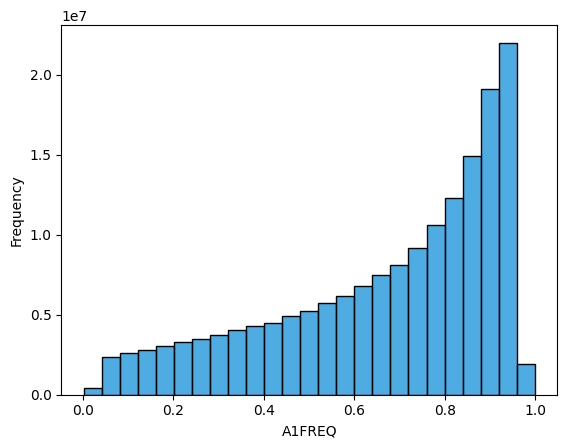

In [36]:
import seaborn as sns

sns.histplot(
    data=gwas_combo,  # gwas_combo_sample,
    x="A1FREQ",
    bins=25,
    kde=False,
    stat="frequency",
    color="#1290D9",
)

plt.savefig(
    os.path.join(PLOTS_loc, "histogram.EAF.COMBINED.png"),
    dpi=300,
    bbox_inches="tight",
    format="png",
)
plt.savefig(
    os.path.join(PLOTS_loc, "histogram.EAF.COMBINED.pdf"),
    dpi=300,
    bbox_inches="tight",
    format="pdf",
)

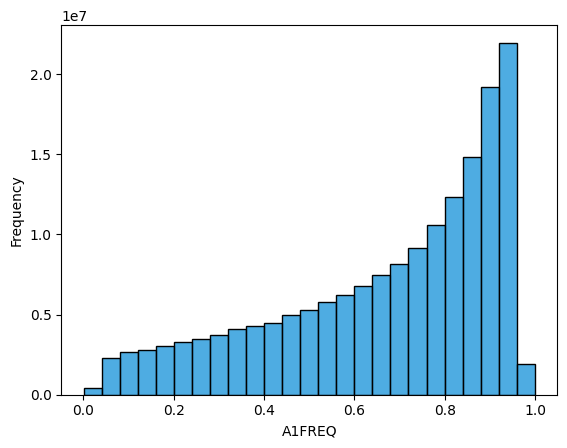

In [37]:
import seaborn as sns

sns.histplot(
    data=gwas_women,  # gwas_combo_sample,
    x="A1FREQ",
    bins=25,
    kde=False,
    stat="frequency",
    color="#1290D9",
)

plt.savefig(
    os.path.join(PLOTS_loc, "histogram.EAF.WOMEN.png"),
    dpi=300,
    bbox_inches="tight",
    format="png",
)
plt.savefig(
    os.path.join(PLOTS_loc, "histogram.EAF.WOMEN.pdf"),
    dpi=300,
    bbox_inches="tight",
    format="pdf",
)

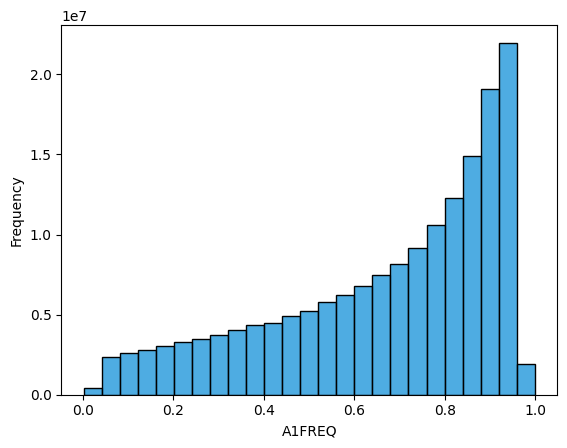

In [38]:
import seaborn as sns

sns.histplot(
    data=gwas_men,  # gwas_combo_sample,
    x="A1FREQ",
    bins=25,
    kde=False,
    stat="frequency",
    color="#1290D9",
)

plt.savefig(
    os.path.join(PLOTS_loc, "histogram.EAF.MEN.png"),
    dpi=300,
    bbox_inches="tight",
    format="png",
)
plt.savefig(
    os.path.join(PLOTS_loc, "histogram.EAF.MEN.pdf"),
    dpi=300,
    bbox_inches="tight",
    format="pdf",
)

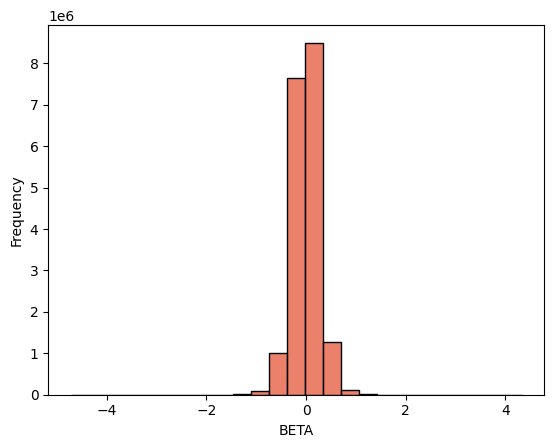

In [39]:
sns.histplot(
    data=gwas_combo,  # gwas_combo_sample,
    x="BETA",
    bins=25,
    kde=False,
    stat="frequency",
    color="#E55738",
)

plt.savefig(
    os.path.join(PLOTS_loc, "histogram.effect.COMBINED.png"),
    dpi=300,
    bbox_inches="tight",
    format="png",
)
plt.savefig(
    os.path.join(PLOTS_loc, "histogram.effect.COMBINED.pdf"),
    dpi=300,
    bbox_inches="tight",
    format="pdf",
)

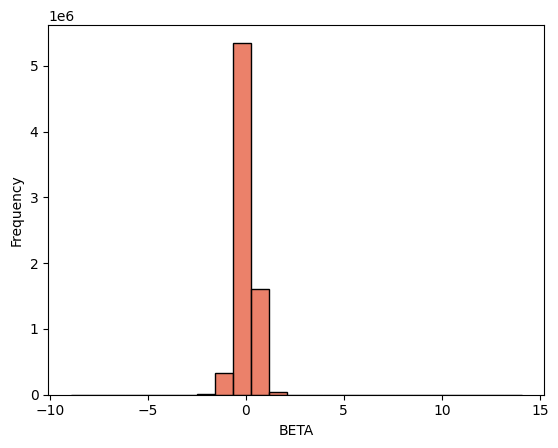

In [40]:
sns.histplot(
    data=gwas_women,  # gwas_combo_sample,
    x="BETA",
    bins=25,
    kde=False,
    stat="frequency",
    color="#E55738",
)

plt.savefig(
    os.path.join(PLOTS_loc, "histogram.effect.WOMEN.png"),
    dpi=300,
    bbox_inches="tight",
    format="png",
)
plt.savefig(
    os.path.join(PLOTS_loc, "histogram.effect.WOMEN.pdf"),
    dpi=300,
    bbox_inches="tight",
    format="pdf",
)

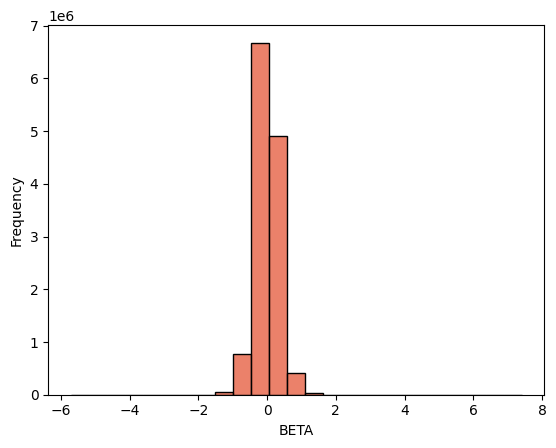

In [41]:
sns.histplot(
    data=gwas_men,  # gwas_combo_sample,
    x="BETA",
    bins=25,
    kde=False,
    stat="frequency",
    color="#E55738",
)

plt.savefig(
    os.path.join(PLOTS_loc, "histogram.effect.MEN.png"),
    dpi=300,
    bbox_inches="tight",
    format="png",
)
plt.savefig(
    os.path.join(PLOTS_loc, "histogram.effect.MEN.pdf"),
    dpi=300,
    bbox_inches="tight",
    format="pdf",
)

### SumStats quality control

Here we first check and fix headers, and contents of the SumStats object.

First, we load the data and inspect it using `GWASLab`. Note that for this to work, some column types need to be adjusted..

In [42]:
gwas_combo[["CHR"]] = gwas_combo[["CHR"]].astype("Int64")

gwas_women[["CHR"]] = gwas_women[["CHR"]].astype("Int64")

gwas_men[["CHR"]] = gwas_men[["CHR"]].astype("Int64")

In [43]:
gwas_combo[["BP"]] = gwas_combo[["BP"]].astype("Int64")

gwas_women[["BP"]] = gwas_women[["BP"]].astype("Int64")

gwas_men[["BP"]] = gwas_men[["BP"]].astype("Int64")

In [44]:
# create new SNPID column based on chromosome, position, and alleles
# down the road we need an SNPID column to merge with the reference data and which does not contain 'ID' because this is not correctly interpreted by GWASLab

gwas_combo["CHRBPID"] = (
    gwas_combo["CHR"].astype(str) + ":" + gwas_combo["BP"].astype(str)
)
# from an *.out file at /hpc/dhl_ec/svanderlaan/projects/sign/vonberg_joanna/2.Age.of.onset/linreg_aoo_unrestricted_bolt/eur.everything.butwhi/group
gwas_combo["N"] = 12145

In [45]:
gwas_women["CHRBPID"] = (
    gwas_women["CHR"].astype(str) + ":" + gwas_women["BP"].astype(str)
)
# from an *.out file at /hpc/dhl_ec/svanderlaan/projects/sign/vonberg_joanna/2.Age.of.onset/linreg_aoo_unrestricted_bolt/eur.everything.butwhi/xx.group
gwas_women["N"] = 5344

In [46]:
gwas_men["CHRBPID"] = gwas_men["CHR"].astype(
    str) + ":" + gwas_men["BP"].astype(str)
gwas_men[
    "N"
] = 6801  # from an *.out file at /hpc/dhl_ec/svanderlaan/projects/sign/vonberg_joanna/2.Age.of.onset/linreg_aoo_unrestricted_bolt/eur.everything.butwhi/xy.group

In [47]:
gwas_combo.head()

,SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,INFO,BETA,SE,P_BOLT_LMM_INF,CHRBPID,N
0,rs58108140,1,10583,0,G,A,0.850249,0.301118,-0.658801,0.423637,0.12,1:10583,12145
1,rs180734498,1,13302,0,C,T,0.906641,0.332755,-0.139703,0.509556,0.78,1:13302,12145
2,rs140337953,1,30923,0,G,T,0.165905,0.330267,0.317905,0.403550,0.43,1:30923,12145
3,rs116400033,1,51479,0,T,A,0.819279,0.318227,-0.199339,0.383897,0.60,1:51479,12145
4,rs141149254,1,54490,0,G,A,0.823351,0.322577,-0.035508,0.383277,0.93,1:54490,12145


In [48]:
gwas_women.head()

,SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,INFO,BETA,SE,P_BOLT_LMM_INF,CHRBPID,N
0,rs58108140,1,10583,0,G,A,0.848383,0.301118,-0.824988,0.659326,0.21,1:10583,5344
1,rs180734498,1,13302,0,C,T,0.907042,0.332755,-0.659718,0.806601,0.41,1:13302,5344
2,rs140337953,1,30923,0,G,T,0.166339,0.330267,0.782017,0.644221,0.22,1:30923,5344
3,rs116400033,1,51479,0,T,A,0.816609,0.318227,-0.173976,0.602009,0.77,1:51479,5344
4,rs141149254,1,54490,0,G,A,0.820977,0.322577,0.308928,0.603387,0.61,1:54490,5344


In [49]:
gwas_men.head()

,SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,INFO,BETA,SE,P_BOLT_LMM_INF,CHRBPID,N
0,rs58108140,1,10583,0,G,A,0.851716,0.301118,-0.519809,0.549089,0.34,1:10583,6801
1,rs180734498,1,13302,0,C,T,0.906325,0.332755,0.271376,0.651686,0.68,1:13302,6801
2,rs140337953,1,30923,0,G,T,0.165563,0.330267,-0.002467,0.513017,1.00,1:30923,6801
3,rs116400033,1,51479,0,T,A,0.821378,0.318227,-0.265338,0.494794,0.59,1:51479,6801
4,rs141149254,1,54490,0,G,A,0.825216,0.322577,-0.371793,0.492553,0.45,1:54490,6801


In [50]:
gwas_combo.rename(columns={"SNP": "VariantID"}, inplace=True)
gwas_women.rename(columns={"SNP": "VariantID"}, inplace=True)
gwas_men.rename(columns={"SNP": "VariantID"}, inplace=True)

In [51]:
import gwaslab as gl

# Specify the columns:
gwas_combo_sumstats = gl.Sumstats(
    gwas_combo,
    snpid="CHRBPID",
    # rsid="SNPID", # not available
    chrom="CHR",
    pos="BP",
    ea="ALLELE1",
    nea="ALLELE0",
    eaf="A1FREQ",
    beta="BETA",
    se="SE",
    p="P_BOLT_LMM_INF",
    # direction="Direction",  # only for meta-GWAS
    n="N",
    # info="Info", # not available
    other=["VariantID", "INFO"],
    build="19",
    verbose=True,
)

Sun Sep 17 12:31:11 2023 GWASLab v3.4.25 https://cloufield.github.io/gwaslab/
Sun Sep 17 12:31:11 2023 (C) 2022-2023, Yunye He, Kamatani Lab, MIT License, gwaslab@gmail.com
Sun Sep 17 12:31:11 2023 Start to initiate from pandas DataFrame ...
Sun Sep 17 12:31:17 2023  -Reading columns          : A1FREQ,BETA,N,CHRBPID,INFO,ALLELE0,VariantID,P_BOLT_LMM_INF,SE,BP,CHR,ALLELE1
Sun Sep 17 12:31:17 2023  -Renaming columns to      : EAF,BETA,N,SNPID,INFO,NEA,VariantID,P,SE,POS,CHR,EA
Sun Sep 17 12:31:17 2023  -Current Dataframe shape : 6750263  x  12
Sun Sep 17 12:31:20 2023  -Initiating a status column: STATUS ...
Sun Sep 17 12:31:23 2023 Start to reorder the columns...
Sun Sep 17 12:31:23 2023  -Current Dataframe shape : 6750263  x  13
Sun Sep 17 12:31:23 2023  -Reordering columns to    : SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID
Sun Sep 17 12:31:23 2023 Finished sorting columns successfully!
Sun Sep 17 12:31:24 2023  -Column: SNPID  CHR    POS   EA       NEA      EAF     BET

In [52]:
import gwaslab as gl

# Specify the columns:
gwas_women_sumstats = gl.Sumstats(
    gwas_women,
    snpid="CHRBPID",
    # rsid="SNPID", # not available
    chrom="CHR",
    pos="BP",
    ea="ALLELE1",
    nea="ALLELE0",
    eaf="A1FREQ",
    beta="BETA",
    se="SE",
    p="P_BOLT_LMM_INF",
    # direction="Direction",  # only for meta-GWAS
    n="N",
    # info="Info", # not available
    other=["VariantID", "INFO"],
    build="19",
    verbose=True,
)

Sun Sep 17 12:31:24 2023 GWASLab v3.4.25 https://cloufield.github.io/gwaslab/
Sun Sep 17 12:31:24 2023 (C) 2022-2023, Yunye He, Kamatani Lab, MIT License, gwaslab@gmail.com
Sun Sep 17 12:31:24 2023 Start to initiate from pandas DataFrame ...
Sun Sep 17 12:31:29 2023  -Reading columns          : A1FREQ,BETA,N,CHRBPID,INFO,ALLELE0,VariantID,P_BOLT_LMM_INF,SE,BP,CHR,ALLELE1
Sun Sep 17 12:31:29 2023  -Renaming columns to      : EAF,BETA,N,SNPID,INFO,NEA,VariantID,P,SE,POS,CHR,EA
Sun Sep 17 12:31:29 2023  -Current Dataframe shape : 6750263  x  12
Sun Sep 17 12:31:31 2023  -Initiating a status column: STATUS ...
Sun Sep 17 12:31:33 2023 Start to reorder the columns...
Sun Sep 17 12:31:33 2023  -Current Dataframe shape : 6750263  x  13
Sun Sep 17 12:31:33 2023  -Reordering columns to    : SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID
Sun Sep 17 12:31:33 2023 Finished sorting columns successfully!
Sun Sep 17 12:31:33 2023  -Column: SNPID  CHR    POS   EA       NEA      EAF     BET

In [53]:
import gwaslab as gl

# Specify the columns:
gwas_men_sumstats = gl.Sumstats(
    gwas_men,
    snpid="CHRBPID",
    # rsid="SNPID", # not available
    chrom="CHR",
    pos="BP",
    ea="ALLELE1",
    nea="ALLELE0",
    eaf="A1FREQ",
    beta="BETA",
    se="SE",
    p="P_BOLT_LMM_INF",
    # direction="Direction",  # only for meta-GWAS
    n="N",
    # info="Info", # not available
    other=["VariantID", "INFO"],
    build="19",
    verbose=True,
)

Sun Sep 17 12:31:36 2023 GWASLab v3.4.25 https://cloufield.github.io/gwaslab/
Sun Sep 17 12:31:36 2023 (C) 2022-2023, Yunye He, Kamatani Lab, MIT License, gwaslab@gmail.com
Sun Sep 17 12:31:36 2023 Start to initiate from pandas DataFrame ...
Sun Sep 17 12:31:41 2023  -Reading columns          : A1FREQ,BETA,N,CHRBPID,INFO,ALLELE0,VariantID,P_BOLT_LMM_INF,SE,BP,CHR,ALLELE1
Sun Sep 17 12:31:41 2023  -Renaming columns to      : EAF,BETA,N,SNPID,INFO,NEA,VariantID,P,SE,POS,CHR,EA
Sun Sep 17 12:31:41 2023  -Current Dataframe shape : 6750263  x  12
Sun Sep 17 12:31:43 2023  -Initiating a status column: STATUS ...
Sun Sep 17 12:31:45 2023 Start to reorder the columns...
Sun Sep 17 12:31:45 2023  -Current Dataframe shape : 6750263  x  13
Sun Sep 17 12:31:45 2023  -Reordering columns to    : SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID
Sun Sep 17 12:31:46 2023 Finished sorting columns successfully!
Sun Sep 17 12:31:46 2023  -Column: SNPID  CHR    POS   EA       NEA      EAF     BET

In [54]:
gwas_combo_sumstats.data

,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID
0,1:10583,1,10583,G,A,0.850249,-0.658801,0.423637,0.12,0.301118,12145,1999999,rs58108140
1,1:13302,1,13302,C,T,0.906641,-0.139703,0.509556,0.78,0.332755,12145,1999999,rs180734498
2,1:30923,1,30923,G,T,0.165905,0.317905,0.403550,0.43,0.330267,12145,1999999,rs140337953
3,1:51479,1,51479,T,A,0.819279,-0.199339,0.383897,0.60,0.318227,12145,1999999,rs116400033
4,1:54490,1,54490,G,A,0.823351,-0.035508,0.383277,0.93,0.322577,12145,1999999,rs141149254
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6750258,22:51229855,22,51229855,G,A,0.853726,-0.027140,0.294785,0.93,0.641013,12145,1999999,rs144549712
6750259,22:51233300,22,51233300,C,T,0.664004,0.239342,0.212296,0.26,0.695615,12145,1999999,rs62240042
6750260,22:51236013,22,51236013,A,AT,0.760900,-0.158471,0.241385,0.51,0.668405,12145,1999999,rs200507571
6750261,22:51237063,22,51237063,T,C,0.723106,0.277995,0.224458,0.22,0.696999,12145,1999999,rs3896457


In [55]:
gwas_women_sumstats.data

,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID
0,1:10583,1,10583,G,A,0.848383,-0.824988,0.659326,0.21,0.301118,5344,1999999,rs58108140
1,1:13302,1,13302,C,T,0.907042,-0.659718,0.806601,0.41,0.332755,5344,1999999,rs180734498
2,1:30923,1,30923,G,T,0.166339,0.782017,0.644221,0.22,0.330267,5344,1999999,rs140337953
3,1:51479,1,51479,T,A,0.816609,-0.173976,0.602009,0.77,0.318227,5344,1999999,rs116400033
4,1:54490,1,54490,G,A,0.820977,0.308928,0.603387,0.61,0.322577,5344,1999999,rs141149254
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6750258,22:51229855,22,51229855,G,A,0.851828,0.390056,0.459037,0.40,0.641013,5344,1999999,rs144549712
6750259,22:51233300,22,51233300,C,T,0.660294,0.058844,0.336962,0.86,0.695615,5344,1999999,rs62240042
6750260,22:51236013,22,51236013,A,AT,0.763283,-0.188759,0.383556,0.62,0.668405,5344,1999999,rs200507571
6750261,22:51237063,22,51237063,T,C,0.721628,0.374821,0.356019,0.29,0.696999,5344,1999999,rs3896457


In [56]:
gwas_men_sumstats.data

,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID
0,1:10583,1,10583,G,A,0.851716,-0.519809,0.549089,0.34,0.301118,6801,1999999,rs58108140
1,1:13302,1,13302,C,T,0.906325,0.271376,0.651686,0.68,0.332755,6801,1999999,rs180734498
2,1:30923,1,30923,G,T,0.165563,-0.002467,0.513017,1.00,0.330267,6801,1999999,rs140337953
3,1:51479,1,51479,T,A,0.821378,-0.265338,0.494794,0.59,0.318227,6801,1999999,rs116400033
4,1:54490,1,54490,G,A,0.825216,-0.371793,0.492553,0.45,0.322577,6801,1999999,rs141149254
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6750258,22:51229855,22,51229855,G,A,0.855217,-0.274366,0.381691,0.47,0.641013,6801,1999999,rs144549712
6750259,22:51233300,22,51233300,C,T,0.666920,0.398509,0.270816,0.14,0.695615,6801,1999999,rs62240042
6750260,22:51236013,22,51236013,A,AT,0.759029,-0.175344,0.307649,0.57,0.668405,6801,1999999,rs200507571
6750261,22:51237063,22,51237063,T,C,0.724267,0.245600,0.286446,0.39,0.696999,6801,1999999,rs3896457


In [57]:
gwas_combo_sumstats.summary()

Values  \
Category Items                                                                  
META     Row_num                                                      6750263   
         Column_num                                                        13   
         Column_names       SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STAT...   
         Last_checked_time                           Sun Sep 17 12:31:51 2023   
MISSING  Missing_total                                                      0   
MAF      Common                                                       6544740   
         Low_frequency                                                 202899   
         Rare                                                            2624   
P        Minimum                                                        7e-07   
         Significant                                                        0   
         Suggestive                                                        28   
STATUS   1999999                                                      6750263   

                            Percentage  
Category Items                          
META     Row_num                   NaN  
         Column_num                NaN  
         Column_names              NaN  
         Last_checked_time         NaN  
MISSING  Missing_total            0.00  
MAF      Common                  96.96  
         Low_frequency            3.01  
         Rare                     0.04  
P        Minimum                  0.00  
         Significant              0.00  
         Suggestive               0.00  
STATUS   1999999                100.00

In [58]:
gwas_women_sumstats.summary()

Values  \
Category Items                                                                  
META     Row_num                                                      6750263   
         Column_num                                                        13   
         Column_names       SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STAT...   
         Last_checked_time                           Sun Sep 17 12:31:56 2023   
MISSING  Missing_total                                                      0   
MAF      Common                                                       6540936   
         Low_frequency                                                 206646   
         Rare                                                            2681   
P        Minimum                                                      9.3e-07   
         Significant                                                        0   
         Suggestive                                                        21   
STATUS   1999999                                                      6750263   

                            Percentage  
Category Items                          
META     Row_num                   NaN  
         Column_num                NaN  
         Column_names              NaN  
         Last_checked_time         NaN  
MISSING  Missing_total            0.00  
MAF      Common                  96.90  
         Low_frequency            3.06  
         Rare                     0.04  
P        Minimum                  0.00  
         Significant              0.00  
         Suggestive               0.00  
STATUS   1999999                100.00

In [59]:
gwas_men_sumstats.summary()

Values  \
Category Items                                                                  
META     Row_num                                                      6750263   
         Column_num                                                        13   
         Column_names       SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STAT...   
         Last_checked_time                           Sun Sep 17 12:32:01 2023   
MISSING  Missing_total                                                      0   
MAF      Common                                                       6543452   
         Low_frequency                                                 204173   
         Rare                                                            2637   
P        Minimum                                                      3.7e-08   
         Significant                                                        2   
         Suggestive                                                        12   
STATUS   1999999                                                      6750263   

                            Percentage  
Category Items                          
META     Row_num                   NaN  
         Column_num                NaN  
         Column_names              NaN  
         Last_checked_time         NaN  
MISSING  Missing_total            0.00  
MAF      Common                  96.94  
         Low_frequency            3.02  
         Rare                     0.04  
P        Minimum                  0.00  
         Significant              0.00  
         Suggestive               0.00  
STATUS   1999999                100.00

In [60]:
gwas_combo_sumstats.lookup_status()

,Genome_Build,rsID&SNPID,CHR&POS,Stadardize&Normalize,Align,Panlidromic_SNP&Indel,Count,Percentage(%)
1999999,hg19,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,6750263,100.0


In [61]:
gwas_women_sumstats.lookup_status()

,Genome_Build,rsID&SNPID,CHR&POS,Stadardize&Normalize,Align,Panlidromic_SNP&Indel,Count,Percentage(%)
1999999,hg19,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,6750263,100.0


In [62]:
gwas_men_sumstats.lookup_status()

,Genome_Build,rsID&SNPID,CHR&POS,Stadardize&Normalize,Align,Panlidromic_SNP&Indel,Count,Percentage(%)
1999999,hg19,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,6750263,100.0


#### Intermediate cleaning

Here we cleanup the originally loaded data, to clear memory.

In [63]:
del gwas_combo
del gwas_women
del gwas_men

#### Get reference data

We align the data to the reference genome, this will work for most common variants. Before that, we check which reference datasets are available, and get these.

In [64]:
# check references
gl.check_available_ref()

# {'1kg_eas_hg19': 'https://www.dropbox.com/s/lztaxqhy2o6dpxw/EAS.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?dl=1',
#  '1kg_eas_hg19_md5': 'c8c97434843c0da3113fc06879ead472',
#  '1kg_eas_hg19_tbi': 'https://www.dropbox.com/s/k9klefl8m9fcfo1/EAS.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?dl=1',
#  '1kg_eur_hg19': 'https://www.dropbox.com/s/1nbgqshknevseks/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?dl=1',
#  '1kg_eur_hg19_md5': '734069d895009d38c2f962bfbb6fab52',
#  '1kg_eur_hg19_tbi': 'https://www.dropbox.com/s/vscvkrflh6fc5a0/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?dl=1',
#  '1kg_eas_hg38': 'https://www.dropbox.com/s/3dstbbb1el9r3au/EAS.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?dl=1',
#  '1kg_eas_hg38_md5': 'f45e80bca9ef7b29e6b1832e6ac15375',
#  '1kg_eas_hg38_tbi': 'https://www.dropbox.com/s/vwnp5vd8dcqksn4/EAS.ALL.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?dl=1',
#  '1kg_eur_hg38': 'https://www.dropbox.com/s/z0mkehg17lryapv/EUR.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?dl=1',
#  '1kg_eur_hg38_md5': '228d3285fa99132cc6321e2925e0768d',
#  '1kg_eur_hg38_tbi': 'https://www.dropbox.com/s/ze8g58x75x9qbf0/EUR.ALL.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?dl=1',
#  '1kg_sas_hg19': 'https://www.dropbox.com/scl/fi/fubqvuj3p4ii4y35zknv8/SAS.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?rlkey=5z50f66iltjchcaszznq5bczt&dl=1',
#  '1kg_sas_hg19_md5': 'e2d3f9e2e6580d05e877e9effd435c4e',
#  '1kg_sas_hg19_tbi': 'https://www.dropbox.com/scl/fi/icnmrnzee7ofdpx5l96tg/SAS.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?rlkey=st8t88snby26q37rqi6zh5zck&dl=1',
#  '1kg_amr_hg19': 'https://www.dropbox.com/scl/fi/bxa4zfngsxsc38rhtiv8c/AMR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?rlkey=ibcn8hb1n8n36j3u0jfzci267&dl=1',
#  '1kg_amr_hg19_md5': '68d3cdf01cbabdae6e74a07795fa881c',
#  '1kg_amr_hg19_tbi': 'https://www.dropbox.com/scl/fi/1zk16x7h4r89jurzwu05u/AMR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?rlkey=b4cere4w38zvzyfitfge3r8n0&dl=1',
#  '1kg_sas_hg38': 'https://www.dropbox.com/scl/fi/jr3l5zz42py3kny2bccmj/SAS.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?rlkey=x0t6tsy71jxzf021wfqdn8k5q&dl=1',
#  '1kg_sas_hg38_md5': 'e5d79bea1958aa50c23f618d342ccc83',
#  '1kg_sas_hg38_tbi': 'https://www.dropbox.com/scl/fi/02oia4ur5r7w9qgiuf6i9/SAS.ALL.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?rlkey=00p9rxe0xzfs6hr1rg4d8oadm&dl=1',
#  '1kg_amr_hg38': 'https://www.dropbox.com/scl/fi/4t4tyuhzp78uyb6tgkroq/AMR.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?rlkey=p96gbs1tcdia31jnjv1b82kuz&dl=1',
#  '1kg_amr_hg38_md5': '229fbd610001cf6f137b7f738352a44a',
#  '1kg_amr_hg38_tbi': 'https://www.dropbox.com/scl/fi/x0dby543tr9xpaqj2i0ba/AMR.ALL.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?rlkey=uj8o7j0cy0spipe174jn54sqs&dl=1',
#  '1kg_afr_hg19': 'https://www.dropbox.com/scl/fi/tq4w9lyt5z47ym7grtrxg/AFR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?rlkey=k3bimeu3yr5loq8hohba5mr6k&dl=1',
#  '1kg_afr_hg19_md5': 'f7b4425f39e8292dce6f13711e7f6c50',
#  '1kg_afr_hg19_tbi': 'https://www.dropbox.com/scl/fi/0giiptu0btwj1kfm6jdzr/AFR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?rlkey=ucb5weprsc5prcg8hvtgmruxx&dl=1',
#  '1kg_pan_hg19': 'https://www.dropbox.com/scl/fi/6b4j9z9knmllfnbx86aw6/PAN.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?rlkey=eento8vg06zyrkvooc9wd4cvu&dl=1',
#  '1kg_pan_hg19_md5': 'fed846482204487b60d33b21ddb18106',
#  '1kg_pan_hg19_tbi': 'https://www.dropbox.com/scl/fi/stco946scio5tvto0ln4j/PAN.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?rlkey=hfh53beb627lmqwv3d8mzqy0c&dl=1',
#  '1kg_afr_hg38': 'https://www.dropbox.com/scl/fi/239xmm7qijtnsks97chc9/AFR.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?rlkey=47en5fk1icbekpg7we3uot9g8&dl=1',
#  '1kg_afr_hg38_md5': '3bb7923be0809a324d7b7633b8d58a3b',
#  '1kg_afr_hg38_tbi': 'https://www.dropbox.com/scl/fi/3y3pg4yqwo2jaaamx1c8f/AFR.ALL.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?rlkey=say0ihfwa51z3otgn4bjtze8p&dl=1',
#  '1kg_pan_hg38': 'https://www.dropbox.com/scl/fi/nf01487smtmeq243ihfwm/PAN.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?rlkey=3pefbkzxwcnejx4inynifpft7&dl=1',
#  '1kg_pan_hg38_md5': '23bb86d748c4a66e85e087f647e8b60e',
#  '1kg_pan_hg38_tbi': 'https://www.dropbox.com/scl/fi/hu7cttr4cenw5yjsm2775/PAN.ALL.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?rlkey=568u7bkvkybm4wt2q9284o198&dl=1',
#  'dbsnp_v151_hg19': 'https://ftp.ncbi.nih.gov/snp/organisms/human_9606_b151_GRCh37p13/VCF/00-All.vcf.gz',
#  'dbsnp_v151_hg19_tbi': 'https://ftp.ncbi.nih.gov/snp/organisms/human_9606_b151_GRCh37p13/VCF/00-All.vcf.gz.tbi',
#  'dbsnp_v151_hg38': 'https://ftp.ncbi.nih.gov/snp/organisms/human_9606_b151_GRCh38p7/VCF/00-All.vcf.gz',
#  'dbsnp_v151_hg38_tbi': 'https://ftp.ncbi.nih.gov/snp/organisms/human_9606_b151_GRCh38p7/VCF/00-All.vcf.gz.tbi',
#  'dbsnp_v156_hg19': 'https://ftp.ncbi.nih.gov/snp/archive/b156/VCF/GCF_000001405.25.gz',
#  'dbsnp_v156_hg19_tbi': 'https://ftp.ncbi.nih.gov/snp/archive/b156/VCF/GCF_000001405.25.gz.tbi',
#  'dbsnp_v156_hg38': 'https://ftp.ncbi.nih.gov/snp/archive/b156/VCF/GCF_000001405.40.gz',
#  'dbsnp_v156_hg38_tbi': 'https://ftp.ncbi.nih.gov/snp/archive/b156/VCF/GCF_000001405.40.gz.tbi',
#  'ucsc_genome_hg19': 'http://hgdownload.cse.ucsc.edu/goldenpath/hg19/bigZips/hg19.fa.gz',
#  'ucsc_genome_hg38': 'https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz',
#  '1kg_dbsnp151_hg19_auto': 'https://www.dropbox.com/s/37p2u1xwmux4gwo/1kg_dbsnp151_hg19_auto.txt.gz?dl=1',
#  '1kg_dbsnp151_hg19_auto_md5': '7d1e7624fb6e4df7a2f6f05558d436b4',
#  '1kg_dbsnp151_hg38_auto': 'https://www.dropbox.com/s/ouf60n7gdz6cm0g/1kg_dbsnp151_hg38_auto.txt.gz?dl=1',
#  '1kg_dbsnp151_hg38_auto_md5': '4c7ef2d2415c18c286219e970fdda972',
#  'recombination_hg19': 'https://www.dropbox.com/s/wbesl8haxknonuc/recombination_hg19.tar.gz?dl=1',
#  'recombination_hg38': 'https://www.dropbox.com/s/vuo8mvqx0fpibzj/recombination_hg38.tar.gz?dl=1',
#  'ensembl_hg19_gtf': 'https://ftp.ensembl.org/pub/grch37/current/gtf/homo_sapiens/Homo_sapiens.GRCh37.87.chr.gtf.gz',
#  'ensembl_hg38_gtf': 'https://ftp.ensembl.org/pub/release-109/gtf/homo_sapiens//Homo_sapiens.GRCh38.109.chr.gtf.gz',
#  'refseq_hg19_gtf': 'https://ftp.ncbi.nlm.nih.gov/refseq/H_sapiens/annotation/GRCh37_latest/refseq_identifiers/GRCh37_latest_genomic.gtf.gz',
#  'refseq_hg38_gtf': 'https://ftp.ncbi.nlm.nih.gov/refseq/H_sapiens/annotation/GRCh38_latest/refseq_identifiers/GRCh38_latest_genomic.gtf.gz',
#  'testlink': 'https://www.dropbox.com/s/8u7capwge0ihshu/EAS.chr22.split_norm_af.1kgp3v5.vcf.gz?dl=1',
#  'testlink_tbi': 'https://www.dropbox.com/s/hdneg53t6u1j6ib/EAS.chr22.split_norm_af.1kgp3v5.vcf.gz.tbi?dl=1'}

Sun Sep 17 12:32:06 2023 Start to check available reference files...
Sun Sep 17 12:32:06 2023  - 1kg_eas_hg19  :  https://www.dropbox.com/s/lztaxqhy2o6dpxw/EAS.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?dl=1
Sun Sep 17 12:32:06 2023  - 1kg_eas_hg19_md5  :  c8c97434843c0da3113fc06879ead472
Sun Sep 17 12:32:06 2023  - 1kg_eas_hg19_tbi  :  https://www.dropbox.com/s/k9klefl8m9fcfo1/EAS.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?dl=1
Sun Sep 17 12:32:06 2023  - 1kg_eur_hg19  :  https://www.dropbox.com/s/1nbgqshknevseks/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?dl=1
Sun Sep 17 12:32:06 2023  - 1kg_eur_hg19_md5  :  734069d895009d38c2f962bfbb6fab52
Sun Sep 17 12:32:06 2023  - 1kg_eur_hg19_tbi  :  https://www.dropbox.com/s/vscvkrflh6fc5a0/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?dl=1
Sun Sep 17 12:32:06 2023  - 1kg_eas_hg38  :  https://www.dropbox.com/s/3dstbbb1el9r3au/EAS.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?dl=1
Sun Sep 17 12:32:06 2023  - 1kg_eas_hg38_md5  :  f45e80bca9ef7b29e6b1832e6ac15375

{'1kg_eas_hg19': 'https://www.dropbox.com/s/lztaxqhy2o6dpxw/EAS.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?dl=1',
 '1kg_eas_hg19_md5': 'c8c97434843c0da3113fc06879ead472',
 '1kg_eas_hg19_tbi': 'https://www.dropbox.com/s/k9klefl8m9fcfo1/EAS.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?dl=1',
 '1kg_eur_hg19': 'https://www.dropbox.com/s/1nbgqshknevseks/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?dl=1',
 '1kg_eur_hg19_md5': '734069d895009d38c2f962bfbb6fab52',
 '1kg_eur_hg19_tbi': 'https://www.dropbox.com/s/vscvkrflh6fc5a0/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?dl=1',
 '1kg_eas_hg38': 'https://www.dropbox.com/s/3dstbbb1el9r3au/EAS.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?dl=1',
 '1kg_eas_hg38_md5': 'f45e80bca9ef7b29e6b1832e6ac15375',
 '1kg_eas_hg38_tbi': 'https://www.dropbox.com/s/vwnp5vd8dcqksn4/EAS.ALL.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?dl=1',
 '1kg_eur_hg38': 'https://www.dropbox.com/s/z0mkehg17lryapv/EUR.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?dl=1',
 '1kg_eur_hg38_md5': '228d3285fa99132cc632

In [65]:
# download ref SNPID-rsID table first
# hg19 is the same as GRCh37, which is the same as b37, which is the same as 19
# USCSC Genome Browser hg19, SNP information
gl.download_ref("ucsc_genome_hg19")
# combined 1KG and dbSNP151, hg19, autosomes
gl.download_ref("1kg_dbsnp151_hg19_auto")
# gl.download_ref("refseq_hg19_gtf") # gene annotation, hg19

Sun Sep 17 12:32:06 2023 Start to download  ucsc_genome_hg19  ...
Sun Sep 17 12:32:06 2023  -Downloading to: /Users/slaan3/.gwaslab/hg19.fa.gz
Sun Sep 17 12:32:06 2023  -File /Users/slaan3/.gwaslab/hg19.fa.gz exists.
Sun Sep 17 12:32:06 2023  -Updating record in config file...
Sun Sep 17 12:32:06 2023  -gunzip : /Users/slaan3/.gwaslab/hg19.fa.gz
Sun Sep 17 12:32:22 2023  -Updating record in config file...
Sun Sep 17 12:32:22 2023 Downloaded  ucsc_genome_hg19  successfully!
Sun Sep 17 12:32:22 2023 Start to download  1kg_dbsnp151_hg19_auto  ...
Sun Sep 17 12:32:22 2023  -Downloading to: /Users/slaan3/.gwaslab/1kg_dbsnp151_hg19_auto.txt.gz
Sun Sep 17 12:32:22 2023  -File /Users/slaan3/.gwaslab/1kg_dbsnp151_hg19_auto.txt.gz exists.
Sun Sep 17 12:32:24 2023  -File path: /Users/slaan3/.gwaslab/1kg_dbsnp151_hg19_auto.txt.gz
Sun Sep 17 12:32:24 2023  -MD5 check: 7d1e7624fb6e4df7a2f6f05558d436b4
Sun Sep 17 12:32:24 2023  -MD5 verified.
Sun Sep 17 12:32:24 2023  -Updating record in config file.

In [66]:
gl.download_ref("dbsnp_v156_hg19")

Sun Sep 17 12:32:24 2023 Start to download  dbsnp_v156_hg19  ...
Sun Sep 17 12:32:24 2023  -Downloading to: /Users/slaan3/.gwaslab/GCF_000001405.25.gz
Sun Sep 17 12:32:24 2023  -File /Users/slaan3/.gwaslab/GCF_000001405.25.gz exists.
Sun Sep 17 12:32:24 2023  -Updating record in config file...
Sun Sep 17 12:32:24 2023 Downloaded  dbsnp_v156_hg19  successfully!


In [67]:
gl.download_ref("dbsnp_v156_hg19_tbi")

Sun Sep 17 12:32:24 2023 Start to download  dbsnp_v156_hg19_tbi  ...
Sun Sep 17 12:32:24 2023  -Downloading to: /Users/slaan3/.gwaslab/GCF_000001405.25.gz.tbi
Sun Sep 17 12:32:24 2023  -File /Users/slaan3/.gwaslab/GCF_000001405.25.gz.tbi exists.
Sun Sep 17 12:32:24 2023  -Updating record in config file...
Sun Sep 17 12:32:24 2023 Downloaded  dbsnp_v156_hg19_tbi  successfully!


In [68]:
# download_ref("1kg_eur_hg19") - EUR
gl.download_ref("1kg_eur_hg19")

Sun Sep 17 12:32:24 2023 Start to download  1kg_eur_hg19  ...
Sun Sep 17 12:32:24 2023  -Downloading to: /Users/slaan3/.gwaslab/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz
Sun Sep 17 12:32:24 2023  -File /Users/slaan3/.gwaslab/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz exists.
Sun Sep 17 12:32:32 2023  -File path: /Users/slaan3/.gwaslab/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz
Sun Sep 17 12:32:32 2023  -MD5 check: 734069d895009d38c2f962bfbb6fab52
Sun Sep 17 12:32:32 2023  -MD5 verified.
Sun Sep 17 12:32:32 2023  -Updating record in config file...
Sun Sep 17 12:32:32 2023  -File /Users/slaan3/.gwaslab/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi exists.
Sun Sep 17 12:32:32 2023  -Updating record in config file...
Sun Sep 17 12:32:32 2023  -Downloading to: /Users/slaan3/.gwaslab/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi
Sun Sep 17 12:32:32 2023 Downloaded  1kg_eur_hg19  successfully!


In [69]:
# download_ref("recombination_hg19") - get recombination map for hg19
gl.download_ref("recombination_hg19")

Sun Sep 17 12:32:32 2023 Start to download  recombination_hg19  ...
Sun Sep 17 12:32:32 2023  -Downloading to: /Users/slaan3/.gwaslab/recombination_hg19.tar.gz
Sun Sep 17 12:32:32 2023  -File /Users/slaan3/.gwaslab/recombination_hg19.tar.gz exists.
Sun Sep 17 12:32:32 2023  -Updating record in config file...
Sun Sep 17 12:32:32 2023 Downloaded  recombination_hg19  successfully!


In [70]:
# download_ref("ensembl_hg19_gtf") - get the Ensembl GTF file for hg19
gl.download_ref("ensembl_hg19_gtf")

Sun Sep 17 12:32:32 2023 Start to download  ensembl_hg19_gtf  ...
Sun Sep 17 12:32:32 2023  -Downloading to: /Users/slaan3/.gwaslab/Homo_sapiens.GRCh37.87.chr.gtf.gz
Sun Sep 17 12:32:32 2023  -File /Users/slaan3/.gwaslab/Homo_sapiens.GRCh37.87.chr.gtf.gz exists.
Sun Sep 17 12:32:32 2023  -Updating record in config file...
Sun Sep 17 12:32:32 2023 Downloaded  ensembl_hg19_gtf  successfully!


In [71]:
# download_ref("refseq_hg19_gtf") - get the refseq hg19 gtf file
gl.download_ref("refseq_hg19_gtf")

Sun Sep 17 12:32:32 2023 Start to download  refseq_hg19_gtf  ...
Sun Sep 17 12:32:32 2023  -Downloading to: /Users/slaan3/.gwaslab/GRCh37_latest_genomic.gtf.gz
Sun Sep 17 12:32:32 2023  -File /Users/slaan3/.gwaslab/GRCh37_latest_genomic.gtf.gz exists.
Sun Sep 17 12:32:32 2023  -Updating record in config file...
Sun Sep 17 12:32:32 2023 Downloaded  refseq_hg19_gtf  successfully!


### Basic check, harmonization, normalization, quality control, and filtering

Here we fix the dataset. 

We provide an example code to create a sample-dataset to check out functions. 

In [72]:
# create example data
# gwas_combo_sumstats_sample = gwas_combo_sumstats.random_variants(n=100000)
# gwas_women_sumstats_sample = gwas_women_sumstats.random_variants(n=100000)
# gwas_men_sumstats_sample = gwas_men_sumstats.random_variants(n=100000)

In [73]:
# check the form of the data as it is BEFORE `basic_check` function
# gwas_combo_sumstats_sample.data

#### Basic check

Here we apply basic check to the data, which makes sure that:
- SNPIDs are of the form chr:bp
- orders the data
- all alleles are capitalized
- does sanity checks on data

However, no data is filtered, and normalization (to a reference) is also not applied!

In [74]:
# Execute `bacis_check` function - first we just make sure the data has the expected format, columns, and datatypes.
# gwas_combo_sumstats_sample.basic_check(verbose=True)

In [75]:
# full data
gwas_combo_sumstats.basic_check(verbose=True)

Sun Sep 17 12:32:32 2023 Start to check IDs...
Sun Sep 17 12:32:32 2023  -Current Dataframe shape : 6750263  x  13
Sun Sep 17 12:32:32 2023  -Checking if SNPID is chr:pos:ref:alt...(separator: - ,: , _)
Sun Sep 17 12:32:42 2023 Finished checking IDs successfully!
Sun Sep 17 12:32:42 2023 Start to fix chromosome notation...
Sun Sep 17 12:32:42 2023  -Current Dataframe shape : 6750263  x  13
Sun Sep 17 12:32:42 2023  -Checking CHR data type...
Sun Sep 17 12:32:44 2023  -Variants with standardized chromosome notation: 6750263
Sun Sep 17 12:32:46 2023  -All CHR are already fixed...
Sun Sep 17 12:32:54 2023  -Sanity check for CHR...
Sun Sep 17 12:32:56 2023  -Removed 0 varaints with CHR < 1...
Sun Sep 17 12:33:01 2023 Finished fixing chromosome notation successfully!
Sun Sep 17 12:33:01 2023 Start to fix basepair positions...
Sun Sep 17 12:33:01 2023  -Current Dataframe shape : 6750263  x  13
Sun Sep 17 12:33:01 2023  -Converting to Int64 data type ...
Sun Sep 17 12:33:08 2023  -Position up

In [76]:
# full data
gwas_women_sumstats.basic_check(verbose=True)

Sun Sep 17 12:34:03 2023 Start to check IDs...
Sun Sep 17 12:34:03 2023  -Current Dataframe shape : 6750263  x  13
Sun Sep 17 12:34:03 2023  -Checking if SNPID is chr:pos:ref:alt...(separator: - ,: , _)
Sun Sep 17 12:34:11 2023 Finished checking IDs successfully!
Sun Sep 17 12:34:11 2023 Start to fix chromosome notation...
Sun Sep 17 12:34:11 2023  -Current Dataframe shape : 6750263  x  13
Sun Sep 17 12:34:11 2023  -Checking CHR data type...
Sun Sep 17 12:34:14 2023  -Variants with standardized chromosome notation: 6750263
Sun Sep 17 12:34:16 2023  -All CHR are already fixed...
Sun Sep 17 12:34:24 2023  -Sanity check for CHR...
Sun Sep 17 12:34:25 2023  -Removed 0 varaints with CHR < 1...
Sun Sep 17 12:34:28 2023 Finished fixing chromosome notation successfully!
Sun Sep 17 12:34:28 2023 Start to fix basepair positions...
Sun Sep 17 12:34:28 2023  -Current Dataframe shape : 6750263  x  13
Sun Sep 17 12:34:28 2023  -Converting to Int64 data type ...
Sun Sep 17 12:34:35 2023  -Position up

In [77]:
# full data
gwas_men_sumstats.basic_check(verbose=True)

Sun Sep 17 12:35:24 2023 Start to check IDs...
Sun Sep 17 12:35:24 2023  -Current Dataframe shape : 6750263  x  13
Sun Sep 17 12:35:24 2023  -Checking if SNPID is chr:pos:ref:alt...(separator: - ,: , _)
Sun Sep 17 12:35:32 2023 Finished checking IDs successfully!
Sun Sep 17 12:35:32 2023 Start to fix chromosome notation...
Sun Sep 17 12:35:32 2023  -Current Dataframe shape : 6750263  x  13
Sun Sep 17 12:35:32 2023  -Checking CHR data type...
Sun Sep 17 12:35:35 2023  -Variants with standardized chromosome notation: 6750263
Sun Sep 17 12:35:37 2023  -All CHR are already fixed...
Sun Sep 17 12:35:45 2023  -Sanity check for CHR...
Sun Sep 17 12:35:47 2023  -Removed 0 varaints with CHR < 1...
Sun Sep 17 12:35:48 2023 Finished fixing chromosome notation successfully!
Sun Sep 17 12:35:48 2023 Start to fix basepair positions...
Sun Sep 17 12:35:48 2023  -Current Dataframe shape : 6750263  x  13
Sun Sep 17 12:35:48 2023  -Converting to Int64 data type ...
Sun Sep 17 12:35:56 2023  -Position up

In [78]:
# check the form of the data as it is AFTER `basic_check` function
# gwas_combo_sumstats_sample.data

In [79]:
# full data
gwas_combo_sumstats.data

,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID
0,1:10583,1,10583,G,A,0.850249,-0.658801,0.423637,0.12,0.301118,12145,1980099,rs58108140
1,1:13302,1,13302,C,T,0.906641,-0.139703,0.509556,0.78,0.332755,12145,1980099,rs180734498
2,1:30923,1,30923,G,T,0.165905,0.317905,0.403550,0.43,0.330267,12145,1980099,rs140337953
3,1:51479,1,51479,T,A,0.819279,-0.199339,0.383897,0.60,0.318227,12145,1980099,rs116400033
4,1:54490,1,54490,G,A,0.823351,-0.035508,0.383277,0.93,0.322577,12145,1980099,rs141149254
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6750258,22:51229855,22,51229855,G,A,0.853726,-0.027140,0.294785,0.93,0.641013,12145,1980099,rs144549712
6750259,22:51233300,22,51233300,C,T,0.664004,0.239342,0.212296,0.26,0.695615,12145,1980099,rs62240042
6750260,22:51236013,22,51236013,A,AT,0.760900,-0.158471,0.241385,0.51,0.668405,12145,1980399,rs200507571
6750261,22:51237063,22,51237063,T,C,0.723106,0.277995,0.224458,0.22,0.696999,12145,1980099,rs3896457


In [80]:
# full data
gwas_women_sumstats.data

,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID
0,1:10583,1,10583,G,A,0.848383,-0.824988,0.659326,0.21,0.301118,5344,1980099,rs58108140
1,1:13302,1,13302,C,T,0.907042,-0.659718,0.806601,0.41,0.332755,5344,1980099,rs180734498
2,1:30923,1,30923,G,T,0.166339,0.782017,0.644221,0.22,0.330267,5344,1980099,rs140337953
3,1:51479,1,51479,T,A,0.816609,-0.173976,0.602009,0.77,0.318227,5344,1980099,rs116400033
4,1:54490,1,54490,G,A,0.820977,0.308928,0.603387,0.61,0.322577,5344,1980099,rs141149254
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6750256,22:51229855,22,51229855,G,A,0.851828,0.390056,0.459037,0.40,0.641013,5344,1980099,rs144549712
6750257,22:51233300,22,51233300,C,T,0.660294,0.058844,0.336962,0.86,0.695615,5344,1980099,rs62240042
6750258,22:51236013,22,51236013,A,AT,0.763283,-0.188759,0.383556,0.62,0.668405,5344,1980399,rs200507571
6750259,22:51237063,22,51237063,T,C,0.721628,0.374821,0.356019,0.29,0.696999,5344,1980099,rs3896457


In [81]:
# full data
gwas_men_sumstats.data

,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID
0,1:10583,1,10583,G,A,0.851716,-0.519809,0.549089,0.34,0.301118,6801,1980099,rs58108140
1,1:13302,1,13302,C,T,0.906325,0.271376,0.651686,0.68,0.332755,6801,1980099,rs180734498
2,1:30923,1,30923,G,T,0.165563,-0.002467,0.513017,1.00,0.330267,6801,1980099,rs140337953
3,1:51479,1,51479,T,A,0.821378,-0.265338,0.494794,0.59,0.318227,6801,1980099,rs116400033
4,1:54490,1,54490,G,A,0.825216,-0.371793,0.492553,0.45,0.322577,6801,1980099,rs141149254
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6750258,22:51229855,22,51229855,G,A,0.855217,-0.274366,0.381691,0.47,0.641013,6801,1980099,rs144549712
6750259,22:51233300,22,51233300,C,T,0.666920,0.398509,0.270816,0.14,0.695615,6801,1980099,rs62240042
6750260,22:51236013,22,51236013,A,AT,0.759029,-0.175344,0.307649,0.57,0.668405,6801,1980399,rs200507571
6750261,22:51237063,22,51237063,T,C,0.724267,0.245600,0.286446,0.39,0.696999,6801,1980099,rs3896457


#### Remove duplicate and multi-allelic variants

Here we remove duplicate and multi-allelic variants, and keep the variants with the lowest P-value for association.

In [82]:
# removing multiallelic and duplicate variants
# mode=d ,remove duplicate.
#     remove duplicate SNPs based on 1. SNPID,
#     remove duplicate SNPs based on 2. CHR, POS, EA, and NEA
#     remove duplicate SNPs based on 3. rsID
# mode=m, remove multiallelic variants.
#     remove multiallelic SNPs based on 4. CHR, POS
# remove=True : remove NAs
# keep_col : use which column to sort the values (keep_ascend=True: ascending order)
# keep: keep 'first' or 'last'.

# gwas_combo_sumstats_sample.remove_dup(
#     mode="md",  # remove multi-allelic and duplicate variants
#     remove=True,  # remove NAs
#     keep_col="P",
#     keep_ascend=True,
#     keep="first",  # keep the first variant, with the lowest p-value (sorted by that column)
# )

In [83]:
# full dataset
gwas_combo_sumstats.remove_dup(
    mode="md",  # remove multi-allelic and duplicate variants
    remove=True,  # remove NAs
    keep_col="P",
    keep_ascend=True,
    # keep the first variant, with the lowest p-value (sorted by that column)
    keep="first",
)

Sun Sep 17 12:36:45 2023 Start to sort the sumstats using P...
Sun Sep 17 12:36:48 2023 Start to remove duplicated variants based on snpid...
Sun Sep 17 12:36:48 2023  -Current Dataframe shape : 6750263  x  13
Sun Sep 17 12:36:48 2023  -Which variant to keep:  first
Sun Sep 17 12:36:59 2023  -Removed  2  based on SNPID...
Sun Sep 17 12:36:59 2023 Start to remove duplicated variants based on CHR,POS,EA and NEA...
Sun Sep 17 12:36:59 2023  -Current Dataframe shape : 6750261  x  13
Sun Sep 17 12:36:59 2023  -Which variant to keep:  first
Sun Sep 17 12:37:09 2023  -Removed  0  based on CHR,POS,EA and NEA...
Sun Sep 17 12:37:09 2023 Start to remove multiallelic variants based on chr:pos...
Sun Sep 17 12:37:09 2023  -Which variant to keep:  first
Sun Sep 17 12:37:16 2023  -Removed  21  multiallelic variants...
Sun Sep 17 12:37:16 2023  -Removed  23  variants in total.
Sun Sep 17 12:37:16 2023  -Sort the coordinates...
Sun Sep 17 12:37:27 2023  -Removing NAs...
Sun Sep 17 12:37:30 2023  -Remo

In [84]:
# full dataset
gwas_women_sumstats.remove_dup(
    mode="md",  # remove multi-allelic and duplicate variants
    remove=True,  # remove NAs
    keep_col="P",
    keep_ascend=True,
    # keep the first variant, with the lowest p-value (sorted by that column)
    keep="first",
)

Sun Sep 17 12:37:30 2023 Start to sort the sumstats using P...
Sun Sep 17 12:37:33 2023 Start to remove duplicated variants based on snpid...
Sun Sep 17 12:37:33 2023  -Current Dataframe shape : 6750261  x  13
Sun Sep 17 12:37:33 2023  -Which variant to keep:  first
Sun Sep 17 12:37:42 2023  -Removed  2  based on SNPID...
Sun Sep 17 12:37:42 2023 Start to remove duplicated variants based on CHR,POS,EA and NEA...
Sun Sep 17 12:37:42 2023  -Current Dataframe shape : 6750259  x  13
Sun Sep 17 12:37:42 2023  -Which variant to keep:  first
Sun Sep 17 12:37:50 2023  -Removed  0  based on CHR,POS,EA and NEA...
Sun Sep 17 12:37:50 2023 Start to remove multiallelic variants based on chr:pos...
Sun Sep 17 12:37:50 2023  -Which variant to keep:  first
Sun Sep 17 12:37:55 2023  -Removed  21  multiallelic variants...
Sun Sep 17 12:37:55 2023  -Removed  23  variants in total.
Sun Sep 17 12:37:55 2023  -Sort the coordinates...
Sun Sep 17 12:38:06 2023  -Removing NAs...
Sun Sep 17 12:38:08 2023  -Remo

In [85]:
# full dataset
gwas_men_sumstats.remove_dup(
    mode="md",  # remove multi-allelic and duplicate variants
    remove=True,  # remove NAs
    keep_col="P",
    keep_ascend=True,
    # keep the first variant, with the lowest p-value (sorted by that column)
    keep="first",
)

Sun Sep 17 12:38:08 2023 Start to sort the sumstats using P...
Sun Sep 17 12:38:10 2023 Start to remove duplicated variants based on snpid...
Sun Sep 17 12:38:10 2023  -Current Dataframe shape : 6750263  x  13
Sun Sep 17 12:38:10 2023  -Which variant to keep:  first
Sun Sep 17 12:38:19 2023  -Removed  2  based on SNPID...
Sun Sep 17 12:38:19 2023 Start to remove duplicated variants based on CHR,POS,EA and NEA...
Sun Sep 17 12:38:19 2023  -Current Dataframe shape : 6750261  x  13
Sun Sep 17 12:38:19 2023  -Which variant to keep:  first
Sun Sep 17 12:38:27 2023  -Removed  0  based on CHR,POS,EA and NEA...
Sun Sep 17 12:38:27 2023 Start to remove multiallelic variants based on chr:pos...
Sun Sep 17 12:38:27 2023  -Which variant to keep:  first
Sun Sep 17 12:38:32 2023  -Removed  21  multiallelic variants...
Sun Sep 17 12:38:32 2023  -Removed  23  variants in total.
Sun Sep 17 12:38:32 2023  -Sort the coordinates...
Sun Sep 17 12:38:42 2023  -Removing NAs...
Sun Sep 17 12:38:44 2023  -Remo

#### Harmonization

Here we harmonize the data with the reference:
- we make sure alleles are oriented according to the reference
- we assign rsIDs
- we flip alleles (and effect sizes), when necessary

##### Align NEA with REF in the reference genome

We check if the non-effect allele is aligned with the reference sequence (`hg19`). The status code will be changed accordingly.

In [86]:
# .check_ref(): Check if NEA is aligned with the reference sequence. After checking, the tracking status code will be changed accordingly.

# gwas_combo_sumstats_sample.check_ref(ref_path=gl.get_path("ucsc_genome_hg19"))

In [95]:
# full dataset
gwas_combo_sumstats.check_ref(ref_path=gl.get_path("ucsc_genome_hg19"),
                              #   chr_dict=gl.get_number_to_NC(build="19")
                              )

Sun Sep 17 12:47:10 2023 Start to check if NEA is aligned with reference sequence...
Sun Sep 17 12:47:10 2023  -Current Dataframe shape : 6750240  x  13
Sun Sep 17 12:47:10 2023  -Reference genome fasta file: /Users/slaan3/.gwaslab/hg19.fa
Sun Sep 17 12:47:10 2023  -Checking records: 1  2  3  4  5  6  7  X  8  9  10  11  12  13  14  15  16  17  18  20  Y  19  22  21  M  
Sun Sep 17 12:51:23 2023  -Variants allele on given reference sequence :  0
Sun Sep 17 12:51:23 2023  -Variants flipped :  6141093
Sun Sep 17 12:51:23 2023   -Raw Matching rate :  90.98%
Sun Sep 17 12:51:23 2023   -Flipping variants rate > 0.85, it is likely that the EA is aligned with REF in the original dataset.
Sun Sep 17 12:51:23 2023  -Variants inferred reverse_complement :  0
Sun Sep 17 12:51:23 2023  -Variants inferred reverse_complement_flipped :  0
Sun Sep 17 12:51:23 2023  -Both allele on genome + unable to distinguish :  609147
Sun Sep 17 12:51:23 2023  -Variants not on given reference sequence :  0


In [96]:
# full dataset
gwas_women_sumstats.check_ref(ref_path=gl.get_path("ucsc_genome_hg19"),
                              #   chr_dict=gl.get_number_to_NC(build="19")
                              )

Sun Sep 17 12:51:23 2023 Start to check if NEA is aligned with reference sequence...
Sun Sep 17 12:51:23 2023  -Current Dataframe shape : 6750238  x  13
Sun Sep 17 12:51:23 2023  -Reference genome fasta file: /Users/slaan3/.gwaslab/hg19.fa
Sun Sep 17 12:51:23 2023  -Checking records: 1  2  3  4  5  6  7  X  8  9  10  11  12  13  14  15  16  17  18  20  Y  19  22  21  M  
Sun Sep 17 12:55:29 2023  -Variants allele on given reference sequence :  0
Sun Sep 17 12:55:29 2023  -Variants flipped :  6141090
Sun Sep 17 12:55:29 2023   -Raw Matching rate :  90.98%
Sun Sep 17 12:55:29 2023   -Flipping variants rate > 0.85, it is likely that the EA is aligned with REF in the original dataset.
Sun Sep 17 12:55:29 2023  -Variants inferred reverse_complement :  0
Sun Sep 17 12:55:29 2023  -Variants inferred reverse_complement_flipped :  0
Sun Sep 17 12:55:29 2023  -Both allele on genome + unable to distinguish :  609148
Sun Sep 17 12:55:29 2023  -Variants not on given reference sequence :  0


In [97]:
# full dataset
gwas_men_sumstats.check_ref(ref_path=gl.get_path("ucsc_genome_hg19"),
                            #   chr_dict=gl.get_number_to_NC(build="19")
                            )

Sun Sep 17 12:55:29 2023 Start to check if NEA is aligned with reference sequence...
Sun Sep 17 12:55:29 2023  -Current Dataframe shape : 6750240  x  13
Sun Sep 17 12:55:29 2023  -Reference genome fasta file: /Users/slaan3/.gwaslab/hg19.fa
Sun Sep 17 12:55:29 2023  -Checking records: 1  2  3  4  5  6  7  X  8  9  10  11  12  13  14  15  16  17  18  20  Y  19  22  21  M  
Sun Sep 17 12:59:36 2023  -Variants allele on given reference sequence :  0
Sun Sep 17 12:59:36 2023  -Variants flipped :  6141092
Sun Sep 17 12:59:36 2023   -Raw Matching rate :  90.98%
Sun Sep 17 12:59:36 2023   -Flipping variants rate > 0.85, it is likely that the EA is aligned with REF in the original dataset.
Sun Sep 17 12:59:36 2023  -Variants inferred reverse_complement :  0
Sun Sep 17 12:59:36 2023  -Variants inferred reverse_complement_flipped :  0
Sun Sep 17 12:59:36 2023  -Both allele on genome + unable to distinguish :  609148
Sun Sep 17 12:59:36 2023  -Variants not on given reference sequence :  0


In [90]:
# we make sure to flipp the alleles based on the status code
# gwas_combo_sumstats_sample.flip_allele_stats()

In [98]:
# full dataset
gwas_combo_sumstats.flip_allele_stats()

Sun Sep 17 13:01:17 2023  -Current Dataframe shape : 6750240  x  13
Sun Sep 17 13:01:29 2023 Start to flip allele-specific stats for SNPs with status xxxxx[35]x: alt->ea , ref->nea ... 
Sun Sep 17 13:01:31 2023  -Flipping 6141093 variants...
Sun Sep 17 13:01:31 2023  -Swapping column: NEA <=> EA...
Sun Sep 17 13:01:36 2023  -Flipping column: BETA = - BETA...
Sun Sep 17 13:01:36 2023  -Flipping column: EAF = 1 - EAF...
Sun Sep 17 13:01:36 2023  -Changed the status for flipped variants : xxxxx[35]x -> xxxxx[12]x
Sun Sep 17 13:01:56 2023 Finished converting successfully!


In [99]:
# full dataset
gwas_women_sumstats.flip_allele_stats()

Sun Sep 17 13:01:56 2023  -Current Dataframe shape : 6750238  x  13
Sun Sep 17 13:02:09 2023 Start to flip allele-specific stats for SNPs with status xxxxx[35]x: alt->ea , ref->nea ... 
Sun Sep 17 13:02:11 2023  -Flipping 6141090 variants...
Sun Sep 17 13:02:11 2023  -Swapping column: NEA <=> EA...
Sun Sep 17 13:02:15 2023  -Flipping column: BETA = - BETA...
Sun Sep 17 13:02:15 2023  -Flipping column: EAF = 1 - EAF...
Sun Sep 17 13:02:15 2023  -Changed the status for flipped variants : xxxxx[35]x -> xxxxx[12]x
Sun Sep 17 13:02:34 2023 Finished converting successfully!


In [100]:
# full dataset
gwas_men_sumstats.flip_allele_stats()

Sun Sep 17 13:02:34 2023  -Current Dataframe shape : 6750240  x  13
Sun Sep 17 13:02:47 2023 Start to flip allele-specific stats for SNPs with status xxxxx[35]x: alt->ea , ref->nea ... 
Sun Sep 17 13:02:49 2023  -Flipping 6141092 variants...
Sun Sep 17 13:02:49 2023  -Swapping column: NEA <=> EA...
Sun Sep 17 13:02:53 2023  -Flipping column: BETA = - BETA...
Sun Sep 17 13:02:53 2023  -Flipping column: EAF = 1 - EAF...
Sun Sep 17 13:02:53 2023  -Changed the status for flipped variants : xxxxx[35]x -> xxxxx[12]x
Sun Sep 17 13:03:13 2023 Finished converting successfully!


In [94]:
# check the form of the data as it is AFTER `check_ref` function
# gwas_combo_sumstats_sample.data

##### Check palindromic SNPs or indistinguishable Indels

Here we check for palindromic variants and indistinguishable INDELs and remove these. 

>> Note that this not done, as we do not have an `1kg_afr_hg19` reference.

In [ ]:
# .infer_strand() - skipped as this is done
# ref_infer= gl.get_path("1kg_eur_hg19"), # reference vcf file
# ref_alt_freq=None,
# maf_threshold=0.40, # maf threshold for strand inference
# remove_snp="", # remove snps from the data
# mode="pi",
# n_cores=1,
# remove_indel=""

# first we check the strand of the data and assign the status code
# gwas_combo_sumstats_sample.infer_strand(ref_infer=gl.get_path("1kg_eur_hg19"), n_cores=6)

# full data
# gwas_combo_sumstats.infer_strand(ref_infer = gl.get_path("1kg_eur_hg19"),
#                                        n_cores=6)
# then we flip the alleles according to the status code
# gwas_combo_sumstats_sample.flip_allele_stats()

In [101]:
gwas_combo_sumstats.infer_strand(
    ref_infer=gl.get_path("1kg_eur_hg19"), n_cores=8)

Sun Sep 17 13:03:13 2023 Start to infer strand for palindromic SNPs...
Sun Sep 17 13:03:13 2023  -Current Dataframe shape : 6750240  x  13
Sun Sep 17 13:03:13 2023  -Reference vcf file: /Users/slaan3/.gwaslab/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz
Sun Sep 17 13:03:13 2023  -Checking prefix for chromosomes in vcf files...
Sun Sep 17 13:03:13 2023  -No prefix for chromosomes in the VCF files.
Sun Sep 17 13:03:18 2023  -Identified  609147  indistinguishable Indels...
Sun Sep 17 13:03:20 2023  -Indistinguishable indels will be inferred from reference vcf ref and alt...
Sun Sep 17 13:05:28 2023   -Indels ea/nea match reference :  3629
Sun Sep 17 13:05:29 2023   -Indels ea/nea need to be flipped :  430275
Sun Sep 17 13:05:31 2023   -Indels with no macthes or no information :  175243


In [102]:
gwas_combo_sumstats.flip_allele_stats()

Sun Sep 17 13:05:31 2023  -Current Dataframe shape : 6750240  x  13
Sun Sep 17 13:05:49 2023 Start to flip allele-specific stats for standardized indels with status xxxx[123][67][6]: alt->ea , ref->nea ... 
Sun Sep 17 13:05:51 2023  -Flipping 430275 variants...
Sun Sep 17 13:05:51 2023  -Swapping column: NEA <=> EA...
Sun Sep 17 13:05:52 2023  -Flipping column: BETA = - BETA...
Sun Sep 17 13:05:52 2023  -Flipping column: EAF = 1 - EAF...
Sun Sep 17 13:05:52 2023  -Changed the status for flipped variants xxxx[123][67]6 -> xxxx[123][67]4
Sun Sep 17 13:05:58 2023 Finished converting successfully!


In [103]:
gwas_women_sumstats.infer_strand(
    ref_infer=gl.get_path("1kg_eur_hg19"), n_cores=8)

Sun Sep 17 13:05:58 2023 Start to infer strand for palindromic SNPs...
Sun Sep 17 13:05:58 2023  -Current Dataframe shape : 6750238  x  13
Sun Sep 17 13:05:58 2023  -Reference vcf file: /Users/slaan3/.gwaslab/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz
Sun Sep 17 13:05:58 2023  -Checking prefix for chromosomes in vcf files...
Sun Sep 17 13:05:58 2023  -No prefix for chromosomes in the VCF files.
Sun Sep 17 13:06:03 2023  -Identified  609148  indistinguishable Indels...
Sun Sep 17 13:06:04 2023  -Indistinguishable indels will be inferred from reference vcf ref and alt...
Sun Sep 17 13:08:06 2023   -Indels ea/nea match reference :  3629
Sun Sep 17 13:08:08 2023   -Indels ea/nea need to be flipped :  430275
Sun Sep 17 13:08:10 2023   -Indels with no macthes or no information :  175244


In [104]:
gwas_women_sumstats.flip_allele_stats()

Sun Sep 17 13:08:10 2023  -Current Dataframe shape : 6750238  x  13
Sun Sep 17 13:08:27 2023 Start to flip allele-specific stats for standardized indels with status xxxx[123][67][6]: alt->ea , ref->nea ... 
Sun Sep 17 13:08:29 2023  -Flipping 430275 variants...
Sun Sep 17 13:08:29 2023  -Swapping column: NEA <=> EA...
Sun Sep 17 13:08:30 2023  -Flipping column: BETA = - BETA...
Sun Sep 17 13:08:30 2023  -Flipping column: EAF = 1 - EAF...
Sun Sep 17 13:08:30 2023  -Changed the status for flipped variants xxxx[123][67]6 -> xxxx[123][67]4
Sun Sep 17 13:08:36 2023 Finished converting successfully!


In [105]:
gwas_men_sumstats.infer_strand(
    ref_infer=gl.get_path("1kg_eur_hg19"), n_cores=8)

Sun Sep 17 13:08:36 2023 Start to infer strand for palindromic SNPs...
Sun Sep 17 13:08:36 2023  -Current Dataframe shape : 6750240  x  13
Sun Sep 17 13:08:36 2023  -Reference vcf file: /Users/slaan3/.gwaslab/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz
Sun Sep 17 13:08:36 2023  -Checking prefix for chromosomes in vcf files...
Sun Sep 17 13:08:36 2023  -No prefix for chromosomes in the VCF files.
Sun Sep 17 13:08:41 2023  -Identified  609148  indistinguishable Indels...
Sun Sep 17 13:08:43 2023  -Indistinguishable indels will be inferred from reference vcf ref and alt...
Sun Sep 17 13:10:45 2023   -Indels ea/nea match reference :  3629
Sun Sep 17 13:10:47 2023   -Indels ea/nea need to be flipped :  430275
Sun Sep 17 13:10:48 2023   -Indels with no macthes or no information :  175244


In [106]:
gwas_men_sumstats.flip_allele_stats()

Sun Sep 17 13:10:49 2023  -Current Dataframe shape : 6750240  x  13
Sun Sep 17 13:11:06 2023 Start to flip allele-specific stats for standardized indels with status xxxx[123][67][6]: alt->ea , ref->nea ... 
Sun Sep 17 13:11:08 2023  -Flipping 430275 variants...
Sun Sep 17 13:11:08 2023  -Swapping column: NEA <=> EA...
Sun Sep 17 13:11:09 2023  -Flipping column: BETA = - BETA...
Sun Sep 17 13:11:09 2023  -Flipping column: EAF = 1 - EAF...
Sun Sep 17 13:11:09 2023  -Changed the status for flipped variants xxxx[123][67]6 -> xxxx[123][67]4
Sun Sep 17 13:11:15 2023 Finished converting successfully!


##### Assign rsID to the data

For the sample dataset this will take not much time. For the whole dataset (8M variants) it will take about 50-60 minutes!

In [ ]:
# rsID annotation based on chr, pos, ref, alt using a VCF file when the SNPID is of the form chr:pos.
# .assign_rsid() options	DataType	Description	Default
# ref_rsid_tsv	string	tsv file path for annotation of commonly used variants using SNPID (like 1:725932:G:A) as key.	-
# ref_rsid_vcf	string	vcf file path for annotation of other variants. .tbi file is also needed.	-
# chr_dict	dict	a dictionary for converting 1-25 to CHR in the vcf files.
# For example, the notation in dbSNP vcf file is based on RefSeq (like NC_000001.10).
# gwaslab provides built-in conversion dictionaries.
# gl.get_number_to_NC(build="19")
# n_cores	int	number of cores to use.

# gwas_combo_sumstats_sample.assign_rsid(
#     n_cores=4,
#     # ref_rsid_tsv = gl.get_path("1kg_dbsnp151_hg19_auto"),
#     ref_rsid_vcf="/Users/slaan3/PLINK/references/dbSNP/GCF_000001405.25.vcf.gz",  # this works when SNPID is in the format chr:pos
#     chr_dict=gl.get_number_to_NC(
#         build="19"
#     ),  # this is needed as in the VCF file, the chromosome is in NC format
# )

We should fix the SNPIDs such that it includes the alleles. This way the assigning of rsID will go smoothly. 

In [113]:
gwas_combo_sumstats.fix_id(fixid=True,
                           forcefixid=True,)

Sun Sep 17 13:49:10 2023 Start to check IDs...
Sun Sep 17 13:49:10 2023  -Current Dataframe shape : 6750240  x  13
Sun Sep 17 13:49:10 2023  -Checking if SNPID is chr:pos:ref:alt...(separator: - ,: , _)
Sun Sep 17 13:49:43 2023  -Filling 0 SNPID using CHR:POS...
Sun Sep 17 13:49:45 2023  -Filling 0 SNPID using CHR:POS:NEA:EA...
Sun Sep 17 13:49:45 2023  -Fixed 0 variants ID...
Sun Sep 17 13:49:45 2023 Finished checking IDs successfully!


In [114]:
gwas_combo_sumstats.data

,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID
0,1:10583,1,10583,A,G,0.149751,0.658801,0.423637,0.12,0.301118,12145,1980019,rs58108140
1,1:13302,1,13302,T,C,0.093359,0.139703,0.509556,0.78,0.332755,12145,1980019,rs180734498
2,1:30923,1,30923,T,G,0.834095,-0.317905,0.403550,0.43,0.330267,12145,1980019,rs140337953
3,1:51479,1,51479,A,T,0.180721,0.199339,0.383897,0.60,0.318227,12145,1980019,rs116400033
4,1:54490,1,54490,A,G,0.176649,0.035508,0.383277,0.93,0.322577,12145,1980019,rs141149254
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6750235,22:51229855,22,51229855,A,G,0.146274,0.027140,0.294785,0.93,0.641013,12145,1980019,rs144549712
6750236,22:51233300,22,51233300,T,C,0.335996,-0.239342,0.212296,0.26,0.695615,12145,1980019,rs62240042
6750237,22:51236013,22,51236013,AT,A,0.239100,0.158471,0.241385,0.51,0.668405,12145,1980364,rs200507571
6750238,22:51237063,22,51237063,C,T,0.276894,-0.277995,0.224458,0.22,0.696999,12145,1980019,rs3896457


In [115]:
gwas_women_sumstats.fix_id(fixid=True,
                           forcefixid=True,)

Sun Sep 17 13:49:45 2023 Start to check IDs...
Sun Sep 17 13:49:45 2023  -Current Dataframe shape : 6750238  x  13
Sun Sep 17 13:49:45 2023  -Checking if SNPID is chr:pos:ref:alt...(separator: - ,: , _)
Sun Sep 17 13:50:17 2023  -Filling 0 SNPID using CHR:POS...
Sun Sep 17 13:50:19 2023  -Filling 0 SNPID using CHR:POS:NEA:EA...
Sun Sep 17 13:50:20 2023  -Fixed 0 variants ID...
Sun Sep 17 13:50:20 2023 Finished checking IDs successfully!


In [116]:
gwas_women_sumstats.data

,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID
0,1:10583,1,10583,A,G,0.151617,0.824988,0.659326,0.21,0.301118,5344,1980019,rs58108140
1,1:13302,1,13302,T,C,0.092958,0.659718,0.806601,0.41,0.332755,5344,1980019,rs180734498
2,1:30923,1,30923,T,G,0.833661,-0.782017,0.644221,0.22,0.330267,5344,1980019,rs140337953
3,1:51479,1,51479,A,T,0.183391,0.173976,0.602009,0.77,0.318227,5344,1980019,rs116400033
4,1:54490,1,54490,A,G,0.179023,-0.308928,0.603387,0.61,0.322577,5344,1980019,rs141149254
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6750233,22:51229855,22,51229855,A,G,0.148172,-0.390056,0.459037,0.40,0.641013,5344,1980019,rs144549712
6750234,22:51233300,22,51233300,T,C,0.339706,-0.058844,0.336962,0.86,0.695615,5344,1980019,rs62240042
6750235,22:51236013,22,51236013,AT,A,0.236717,0.188759,0.383556,0.62,0.668405,5344,1980364,rs200507571
6750236,22:51237063,22,51237063,C,T,0.278372,-0.374821,0.356019,0.29,0.696999,5344,1980019,rs3896457


In [117]:
gwas_men_sumstats.fix_id(fixid=True,
                         forcefixid=True,)

Sun Sep 17 13:50:21 2023 Start to check IDs...
Sun Sep 17 13:50:21 2023  -Current Dataframe shape : 6750240  x  13
Sun Sep 17 13:50:21 2023  -Checking if SNPID is chr:pos:ref:alt...(separator: - ,: , _)
Sun Sep 17 13:50:53 2023  -Filling 0 SNPID using CHR:POS...
Sun Sep 17 13:50:54 2023  -Filling 0 SNPID using CHR:POS:NEA:EA...
Sun Sep 17 13:50:55 2023  -Fixed 0 variants ID...
Sun Sep 17 13:50:55 2023 Finished checking IDs successfully!


In [119]:
gwas_men_sumstats.data

,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID
0,1:10583,1,10583,A,G,0.148284,0.519809,0.549089,0.34,0.301118,6801,1980019,rs58108140
1,1:13302,1,13302,T,C,0.093675,-0.271376,0.651686,0.68,0.332755,6801,1980019,rs180734498
2,1:30923,1,30923,T,G,0.834437,0.002467,0.513017,1.00,0.330267,6801,1980019,rs140337953
3,1:51479,1,51479,A,T,0.178622,0.265338,0.494794,0.59,0.318227,6801,1980019,rs116400033
4,1:54490,1,54490,A,G,0.174784,0.371793,0.492553,0.45,0.322577,6801,1980019,rs141149254
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6750235,22:51229855,22,51229855,A,G,0.144783,0.274366,0.381691,0.47,0.641013,6801,1980019,rs144549712
6750236,22:51233300,22,51233300,T,C,0.333080,-0.398509,0.270816,0.14,0.695615,6801,1980019,rs62240042
6750237,22:51236013,22,51236013,AT,A,0.240971,0.175344,0.307649,0.57,0.668405,6801,1980364,rs200507571
6750238,22:51237063,22,51237063,C,T,0.275733,-0.245600,0.286446,0.39,0.696999,6801,1980019,rs3896457


In [120]:
gwas_combo_sumstats.assign_rsid(
    n_cores=8,
    # this works for common variants
    ref_rsid_tsv=gl.get_path("1kg_dbsnp151_hg19_auto"),
    ref_rsid_vcf=gl.get_path("dbsnp_v156_hg19"),
    chr_dict=gl.get_number_to_NC(
        build="19"
    ),  # this is needed as in the VCF file, the chromosome is in NC format
)

Sun Sep 17 13:55:30 2023 Start to annotate rsID based on chromosome and position information...
Sun Sep 17 13:55:30 2023  -Current Dataframe shape : 6750240  x  13
Sun Sep 17 13:55:30 2023  -SNPID-rsID text file: /Users/slaan3/.gwaslab/1kg_dbsnp151_hg19_auto.txt.gz
Sun Sep 17 13:55:35 2023  -6750240 rsID could be possibly fixed...
Sun Sep 17 13:55:37 2023  -Setting block size:  5000000
Sun Sep 17 13:55:37 2023  -Loading block: 0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   
Sun Sep 17 14:01:06 2023  -rsID Annotation for 6750240 need to be fixed!
Sun Sep 17 14:01:06 2023  -Annotated 0 rsID successfully!
Sun Sep 17 14:01:06 2023 Start to assign rsID using vcf...
Sun Sep 17 14:01:06 2023  -Current Dataframe shape : 6750240  x  14
Sun Sep 17 14:01:06 2023  -CPU Cores to use : 8
Sun Sep 17 14:01:06 2023  -Reference VCF file: /Users/slaan3/.gwaslab/GCF_000001405.25.gz
Sun Sep 17 14:01:06 2023  -Assigning rsID based on chr:pos and ref:alt/alt:ref...


[W::vcf_parse_info] Extreme INFO/RS value encountered and set to missing at NC_000017.10:12744912
[W::vcf_parse_info] Extreme INFO/RS value encountered and set to missing at NC_000004.11:53858915
[W::vcf_parse_info] Extreme INFO/RS value encountered and set to missing at NC_000006.11:20757153
[W::vcf_parse_info] Extreme INFO/RS value encountered and set to missing at NC_000013.10:43435662
[W::vcf_parse_info] Extreme INFO/RS value encountered and set to missing at NC_000002.11:144956875
[W::vcf_parse_info] Extreme INFO/RS value encountered and set to missing at NC_000008.10:11757032
[W::vcf_parse_info] Extreme INFO/RS value encountered and set to missing at NC_000001.10:6375812
[W::vcf_parse_info] Extreme INFO/RS value encountered and set to missing at NC_000011.9:19778555


Sun Sep 17 14:24:02 2023  -rsID Annotation for 93365 need to be fixed!
Sun Sep 17 14:24:02 2023  -Annotated 6656875 rsID successfully!


In [121]:
gwas_combo_sumstats.summary()

Values  \
Category Items                                                                  
META     Row_num                                                      6750240   
         Column_num                                                        14   
         Column_names       SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STAT...   
         Last_checked_time                           Sun Sep 17 14:24:03 2023   
MISSING  Missing_total                                                  93365   
         Missing_rsID                                                   93365   
MAF      Common                                                       6544717   
         Low_frequency                                                 202899   
         Rare                                                            2624   
P        Minimum                                                        7e-07   
         Significant                                                        0   
         Suggestive                                                        28   
STATUS   1980019                                                      6048896   
         1980364                                                       430275   
         1980368                                                       175243   
         1980319                                                        92197   
         1980363                                                         3629   

                            Percentage  
Category Items                          
META     Row_num                   NaN  
         Column_num                NaN  
         Column_names              NaN  
         Last_checked_time         NaN  
MISSING  Missing_total            1.38  
         Missing_rsID             1.38  
MAF      Common                  96.96  
         Low_frequency            3.01  
         Rare                     0.04  
P        Minimum                  0.00  
         Significant              0.00  
         Suggestive               0.00  
STATUS   1980019                 89.61  
         1980364                  6.37  
         1980368                  2.60  
         1980319                  1.37  
         1980363                  0.05

In [122]:
gwas_women_sumstats.assign_rsid(
    n_cores=8,
    # this works for common variants
    ref_rsid_tsv=gl.get_path("1kg_dbsnp151_hg19_auto"),
    ref_rsid_vcf=gl.get_path("dbsnp_v156_hg19"),
    chr_dict=gl.get_number_to_NC(
        build="19"
    ),  # this is needed as in the VCF file, the chromosome is in NC format
)

Sun Sep 17 14:24:10 2023 Start to annotate rsID based on chromosome and position information...
Sun Sep 17 14:24:10 2023  -Current Dataframe shape : 6750238  x  13
Sun Sep 17 14:24:10 2023  -SNPID-rsID text file: /Users/slaan3/.gwaslab/1kg_dbsnp151_hg19_auto.txt.gz
Sun Sep 17 14:24:14 2023  -6750238 rsID could be possibly fixed...
Sun Sep 17 14:24:16 2023  -Setting block size:  5000000
Sun Sep 17 14:24:16 2023  -Loading block: 0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   
Sun Sep 17 14:29:29 2023  -rsID Annotation for 6750238 need to be fixed!
Sun Sep 17 14:29:29 2023  -Annotated 0 rsID successfully!
Sun Sep 17 14:29:30 2023 Start to assign rsID using vcf...
Sun Sep 17 14:29:30 2023  -Current Dataframe shape : 6750238  x  14
Sun Sep 17 14:29:30 2023  -CPU Cores to use : 8
Sun Sep 17 14:29:30 2023  -Reference VCF file: /Users/slaan3/.gwaslab/GCF_000001405.25.gz
Sun Sep 17 14:29:30 2023  -Assigning rsID based on chr:pos and ref:alt/alt:ref...


[W::vcf_parse_info] Extreme INFO/RS value encountered and set to missing at NC_000017.10:12744912
[W::vcf_parse_info] Extreme INFO/RS value encountered and set to missing at NC_000004.11:53858915
[W::vcf_parse_info] Extreme INFO/RS value encountered and set to missing at NC_000006.11:20757153
[W::vcf_parse_info] Extreme INFO/RS value encountered and set to missing at NC_000013.10:43435662
[W::vcf_parse_info] Extreme INFO/RS value encountered and set to missing at NC_000002.11:144956875
[W::vcf_parse_info] Extreme INFO/RS value encountered and set to missing at NC_000008.10:11757032
[W::vcf_parse_info] Extreme INFO/RS value encountered and set to missing at NC_000001.10:6375812
[W::vcf_parse_info] Extreme INFO/RS value encountered and set to missing at NC_000011.9:19778555


Sun Sep 17 14:53:09 2023  -rsID Annotation for 93363 need to be fixed!
Sun Sep 17 14:53:09 2023  -Annotated 6656875 rsID successfully!


In [123]:
gwas_women_sumstats.summary()

Values  \
Category Items                                                                  
META     Row_num                                                      6750238   
         Column_num                                                        14   
         Column_names       SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STAT...   
         Last_checked_time                           Sun Sep 17 14:53:10 2023   
MISSING  Missing_total                                                  93363   
         Missing_rsID                                                   93363   
MAF      Common                                                       6540913   
         Low_frequency                                                 206646   
         Rare                                                            2679   
P        Minimum                                                      9.3e-07   
         Significant                                                        0   
         Suggestive                                                        21   
STATUS   1980019                                                      6048895   
         1980364                                                       430275   
         1980368                                                       175244   
         1980319                                                        92195   
         1980363                                                         3629   

                            Percentage  
Category Items                          
META     Row_num                   NaN  
         Column_num                NaN  
         Column_names              NaN  
         Last_checked_time         NaN  
MISSING  Missing_total            1.38  
         Missing_rsID             1.38  
MAF      Common                  96.90  
         Low_frequency            3.06  
         Rare                     0.04  
P        Minimum                  0.00  
         Significant              0.00  
         Suggestive               0.00  
STATUS   1980019                 89.61  
         1980364                  6.37  
         1980368                  2.60  
         1980319                  1.37  
         1980363                  0.05

In [124]:
gwas_men_sumstats.assign_rsid(
    n_cores=8,
    # this works for common variants
    ref_rsid_tsv=gl.get_path("1kg_dbsnp151_hg19_auto"),
    ref_rsid_vcf=gl.get_path("dbsnp_v156_hg19"),
    chr_dict=gl.get_number_to_NC(
        build="19"
    ),  # this is needed as in the VCF file, the chromosome is in NC format
)

Sun Sep 17 14:53:17 2023 Start to annotate rsID based on chromosome and position information...
Sun Sep 17 14:53:17 2023  -Current Dataframe shape : 6750240  x  13
Sun Sep 17 14:53:17 2023  -SNPID-rsID text file: /Users/slaan3/.gwaslab/1kg_dbsnp151_hg19_auto.txt.gz
Sun Sep 17 14:53:21 2023  -6750240 rsID could be possibly fixed...
Sun Sep 17 14:53:25 2023  -Setting block size:  5000000
Sun Sep 17 14:53:25 2023  -Loading block: 0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   
Sun Sep 17 14:58:50 2023  -rsID Annotation for 6750240 need to be fixed!
Sun Sep 17 14:58:50 2023  -Annotated 0 rsID successfully!
Sun Sep 17 14:58:50 2023 Start to assign rsID using vcf...
Sun Sep 17 14:58:50 2023  -Current Dataframe shape : 6750240  x  14
Sun Sep 17 14:58:50 2023  -CPU Cores to use : 8
Sun Sep 17 14:58:50 2023  -Reference VCF file: /Users/slaan3/.gwaslab/GCF_000001405.25.gz
Sun Sep 17 14:58:50 2023  -Assigning rsID based on chr:pos and ref:alt/alt:ref...


[W::vcf_parse_info] Extreme INFO/RS value encountered and set to missing at NC_000017.10:12744912
[W::vcf_parse_info] Extreme INFO/RS value encountered and set to missing at NC_000004.11:53858915
[W::vcf_parse_info] Extreme INFO/RS value encountered and set to missing at NC_000006.11:20757153
[W::vcf_parse_info] Extreme INFO/RS value encountered and set to missing at NC_000013.10:43435662
[W::vcf_parse_info] Extreme INFO/RS value encountered and set to missing at NC_000002.11:144956875
[W::vcf_parse_info] Extreme INFO/RS value encountered and set to missing at NC_000008.10:11757032
[W::vcf_parse_info] Extreme INFO/RS value encountered and set to missing at NC_000001.10:6375812
[W::vcf_parse_info] Extreme INFO/RS value encountered and set to missing at NC_000011.9:19778555


Sun Sep 17 15:22:15 2023  -rsID Annotation for 93358 need to be fixed!
Sun Sep 17 15:22:15 2023  -Annotated 6656882 rsID successfully!


In [125]:
gwas_men_sumstats.summary()

Values  \
Category Items                                                                  
META     Row_num                                                      6750240   
         Column_num                                                        14   
         Column_names       SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STAT...   
         Last_checked_time                           Sun Sep 17 15:22:16 2023   
MISSING  Missing_total                                                  93358   
         Missing_rsID                                                   93358   
MAF      Common                                                       6543430   
         Low_frequency                                                 204173   
         Rare                                                            2637   
P        Minimum                                                      3.7e-08   
         Significant                                                        2   
         Suggestive                                                        12   
STATUS   1980019                                                      6048902   
         1980364                                                       430275   
         1980368                                                       175244   
         1980319                                                        92190   
         1980363                                                         3629   

                            Percentage  
Category Items                          
META     Row_num                   NaN  
         Column_num                NaN  
         Column_names              NaN  
         Last_checked_time         NaN  
MISSING  Missing_total            1.38  
         Missing_rsID             1.38  
MAF      Common                  96.94  
         Low_frequency            3.02  
         Rare                     0.04  
P        Minimum                  0.00  
         Significant              0.00  
         Suggestive               0.00  
STATUS   1980019                 89.61  
         1980364                  6.37  
         1980368                  2.60  
         1980319                  1.37  
         1980363                  0.05

##### Plot frequencies of data against the reference

We would like to plot the frequency of the GWAS data compared to the reference data. We do this on a random subset of the data (n=200,000) as this is more efficient and should be representative of the full datasets.

In [126]:
gwas_combo_sumstats_sample = gwas_combo_sumstats.random_variants(n=200000)

Sun Sep 17 17:20:53 2023 Start to randomly select variants from the sumstats...
Sun Sep 17 17:20:53 2023  -Number of variants selected from the sumstats: 200000
Sun Sep 17 17:20:54 2023 Finished sampling...


In [127]:
gwas_women_sumstats_sample = gwas_women_sumstats.random_variants(n=200000)

Sun Sep 17 17:20:57 2023 Start to randomly select variants from the sumstats...
Sun Sep 17 17:20:57 2023  -Number of variants selected from the sumstats: 200000
Sun Sep 17 17:20:58 2023 Finished sampling...


In [128]:
gwas_men_sumstats_sample = gwas_men_sumstats.random_variants(n=200000)

Sun Sep 17 17:21:01 2023 Start to randomly select variants from the sumstats...
Sun Sep 17 17:21:01 2023  -Number of variants selected from the sumstats: 200000
Sun Sep 17 17:21:01 2023 Finished sampling...


In [161]:
# gwas_combo_sumstats_sample.check_af(
#     ref_infer=gl.get_path("1kg_eur_hg19"),
#     ref_alt_freq="AF",
#     n_cores=8,
# )

gwas_combo_sumstats.check_af(
    ref_infer=gl.get_path("1kg_eur_hg19"),
    ref_alt_freq="AF",
    n_cores=8,
)

Mon Sep 18 13:38:43 2023 Start to check the difference between EAF and refence vcf alt frequency ...
Mon Sep 18 13:38:43 2023  -Current Dataframe shape : 6750240  x  14
Mon Sep 18 13:38:43 2023  -Reference vcf file: /Users/slaan3/.gwaslab/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz
Mon Sep 18 13:38:43 2023  -CPU Cores to use : 8
Mon Sep 18 13:38:43 2023  -Checking prefix for chromosomes in vcf files...
Mon Sep 18 13:38:44 2023  -No prefix for chromosomes in the VCF files.
Mon Sep 18 13:38:44 2023  -Alternative allele frequency in INFO: AF
Mon Sep 18 13:38:47 2023  -Checking variants: 6750240
Mon Sep 18 13:54:47 2023  - DAF min: 0.9831399021204561
Mon Sep 18 13:54:47 2023  - DAF max: -0.9619789719581604
Mon Sep 18 13:54:47 2023  - DAF sd: 0.03646760210490856
Mon Sep 18 13:54:47 2023  - abs(DAF) min: 0.0
Mon Sep 18 13:54:47 2023  - abs(DAF) max: 0.9831399021204561
Mon Sep 18 13:54:47 2023  - abs(DAF) sd: 0.0327686363121369
Mon Sep 18 13:54:47 2023 Finished allele frequency checking!


Mon Sep 18 15:33:08 2023 Start to plot Reference frequency vs Effect allele frequency plot...
Mon Sep 18 15:33:16 2023  -Plotting valriants:6392538
Mon Sep 18 15:33:20 2023  -Plotting regression line...
Mon Sep 18 15:33:20 2023  -Beta =  0.9861821069079728
Mon Sep 18 15:33:20 2023  -Intercept =  0.0029829832611361073
Mon Sep 18 15:33:20 2023  -R2 =  0.9893733727697197
Mon Sep 18 15:33:20 2023  -Threshold : 0.12
Mon Sep 18 15:33:20 2023  -Variants with relatively large DAF :  61353
Mon Sep 18 15:33:20 2023  -Percentage for variants with relatively large DAF :  0.009597596447608133


/Users/slaan3/miniconda3/envs/gwaslab/lib/python3.8/site-packages/gwaslab/compare_af.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


Mon Sep 18 15:34:02 2023  -Skip saving figures!


(<Figure size 2400x1200 with 2 Axes>,
                SNPID       EAF       DAF   EA NEA       RAF
 38           1:89946  0.144388 -0.128972    T   A  0.273360
 40           1:91536  0.311757 -0.324426    T   G  0.636183
 41           1:91581  0.311412 -0.324771    A   G  0.636183
 42           1:92858  0.150170 -0.129154    T   G  0.279324
 60          1:255923  0.295641  0.166416  GTC   G  0.129225
 ...              ...       ...       ...  ...  ..       ...
 6750114  22:51181519  0.363141 -0.204453    G   A  0.567594
 6750115  22:51181563  0.270460 -0.396538    C   A  0.666998
 6750116  22:51181568  0.273343 -0.397631    G   A  0.670974
 6750118  22:51181620  0.159206 -0.448150    C   T  0.607356
 6750119  22:51181624  0.159206 -0.447156    C   T  0.606362
 
 [61353 rows x 6 columns])

/Users/slaan3/miniconda3/envs/gwaslab/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/slaan3/miniconda3/envs/gwaslab/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


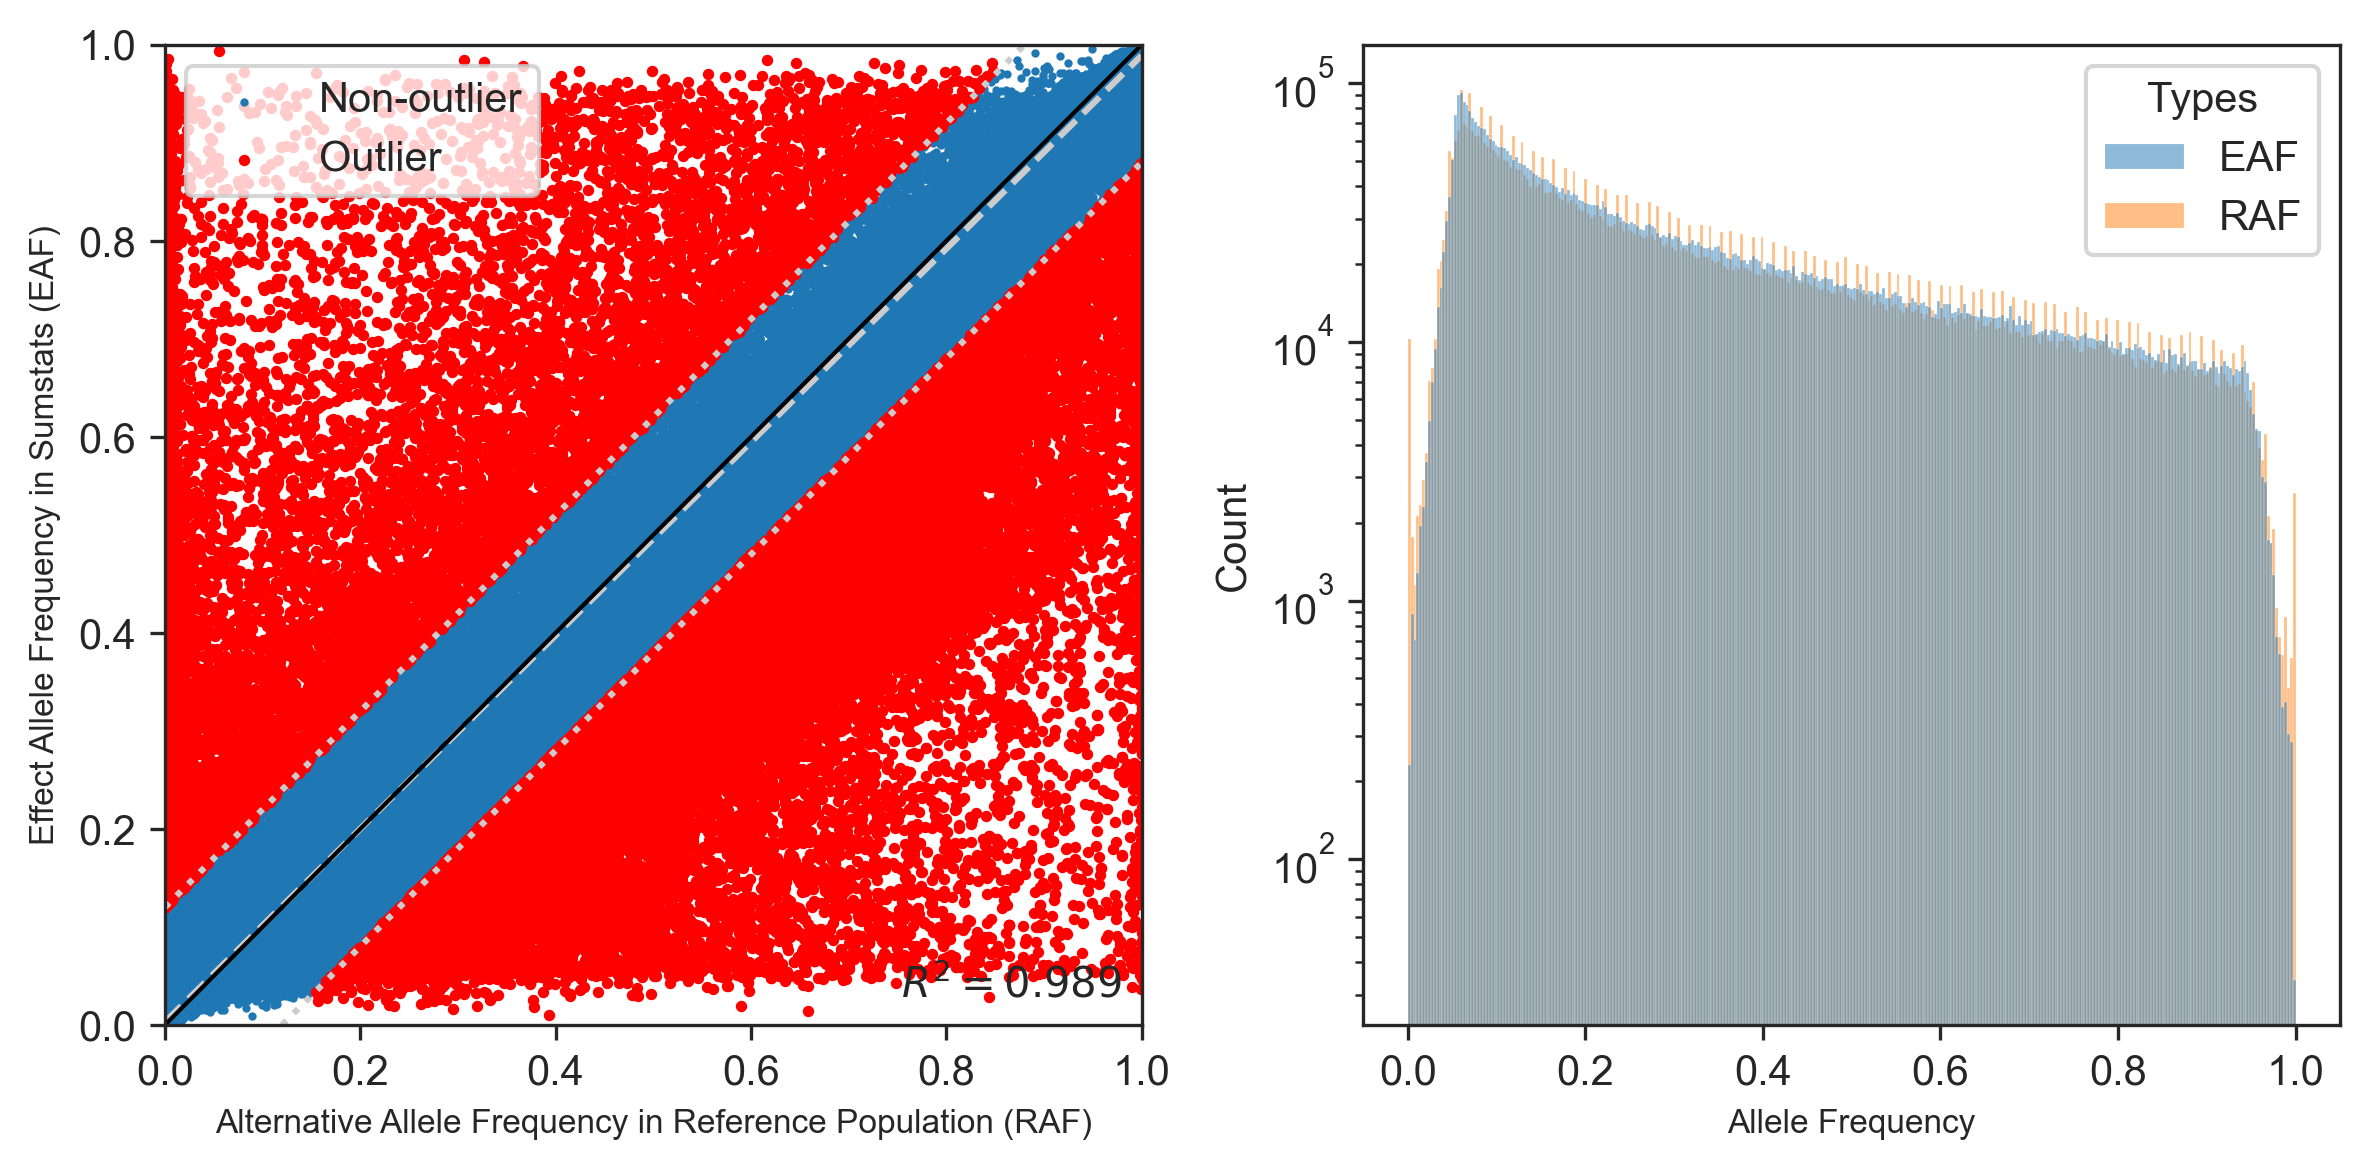

In [180]:
# gwas_combo_sumstats_sample.plot_daf(threshold=0.12)
gwas_combo_sumstats.plot_daf(threshold=0.12)

In [163]:
# gwas_women_sumstats_sample.check_af(
#     ref_infer=gl.get_path("1kg_eur_hg19"),
#     ref_alt_freq="AF",
#     n_cores=8,
# )

gwas_women_sumstats.check_af(
    ref_infer=gl.get_path("1kg_eur_hg19"),
    ref_alt_freq="AF",
    n_cores=8,
)

Mon Sep 18 14:15:23 2023 Start to check the difference between EAF and refence vcf alt frequency ...
Mon Sep 18 14:15:23 2023  -Current Dataframe shape : 6750238  x  14
Mon Sep 18 14:15:23 2023  -Reference vcf file: /Users/slaan3/.gwaslab/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz
Mon Sep 18 14:15:23 2023  -CPU Cores to use : 8
Mon Sep 18 14:15:23 2023  -Checking prefix for chromosomes in vcf files...
Mon Sep 18 14:15:24 2023  -No prefix for chromosomes in the VCF files.
Mon Sep 18 14:15:24 2023  -Alternative allele frequency in INFO: AF
Mon Sep 18 14:15:28 2023  -Checking variants: 6750238
Mon Sep 18 14:32:15 2023  - DAF min: 0.9825259146746248
Mon Sep 18 14:32:15 2023  - DAF max: -0.9604439735412598
Mon Sep 18 14:32:15 2023  - DAF sd: 0.036565908616606656
Mon Sep 18 14:32:15 2023  - abs(DAF) min: 0.0
Mon Sep 18 14:32:15 2023  - abs(DAF) max: 0.9825259146746248
Mon Sep 18 14:32:15 2023  - abs(DAF) sd: 0.03277778387496705
Mon Sep 18 14:32:15 2023 Finished allele frequency checking!


Mon Sep 18 15:37:37 2023 Start to plot Reference frequency vs Effect allele frequency plot...
Mon Sep 18 15:37:42 2023  -Plotting valriants:6392537
Mon Sep 18 15:37:43 2023  -Plotting regression line...
Mon Sep 18 15:37:43 2023  -Beta =  0.9862045992179477
Mon Sep 18 15:37:43 2023  -Intercept =  0.0029826559156921895
Mon Sep 18 15:37:43 2023  -R2 =  0.9893165585230995
Mon Sep 18 15:37:43 2023  -Threshold : 0.12
Mon Sep 18 15:37:43 2023  -Variants with relatively large DAF :  61303
Mon Sep 18 15:37:43 2023  -Percentage for variants with relatively large DAF :  0.00958977632824026


/Users/slaan3/miniconda3/envs/gwaslab/lib/python3.8/site-packages/gwaslab/compare_af.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


Mon Sep 18 15:38:26 2023  -Skip saving figures!


(<Figure size 2400x1200 with 2 Axes>,
                SNPID       EAF       DAF   EA NEA       RAF
 38           1:89946  0.147510 -0.125850    T   A  0.273360
 40           1:91536  0.310627 -0.325556    T   G  0.636183
 41           1:91581  0.310248 -0.325935    A   G  0.636183
 42           1:92858  0.152893 -0.126431    T   G  0.279324
 60          1:255923  0.298492  0.169267  GTC   G  0.129225
 ...              ...       ...       ...  ...  ..       ...
 6750112  22:51181519  0.359822 -0.207772    G   A  0.567594
 6750113  22:51181563  0.270187 -0.396811    C   A  0.666998
 6750114  22:51181568  0.272841 -0.398133    G   A  0.670974
 6750116  22:51181620  0.157873 -0.449483    C   T  0.607356
 6750117  22:51181624  0.157873 -0.448489    C   T  0.606362
 
 [61303 rows x 6 columns])

/Users/slaan3/miniconda3/envs/gwaslab/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/slaan3/miniconda3/envs/gwaslab/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


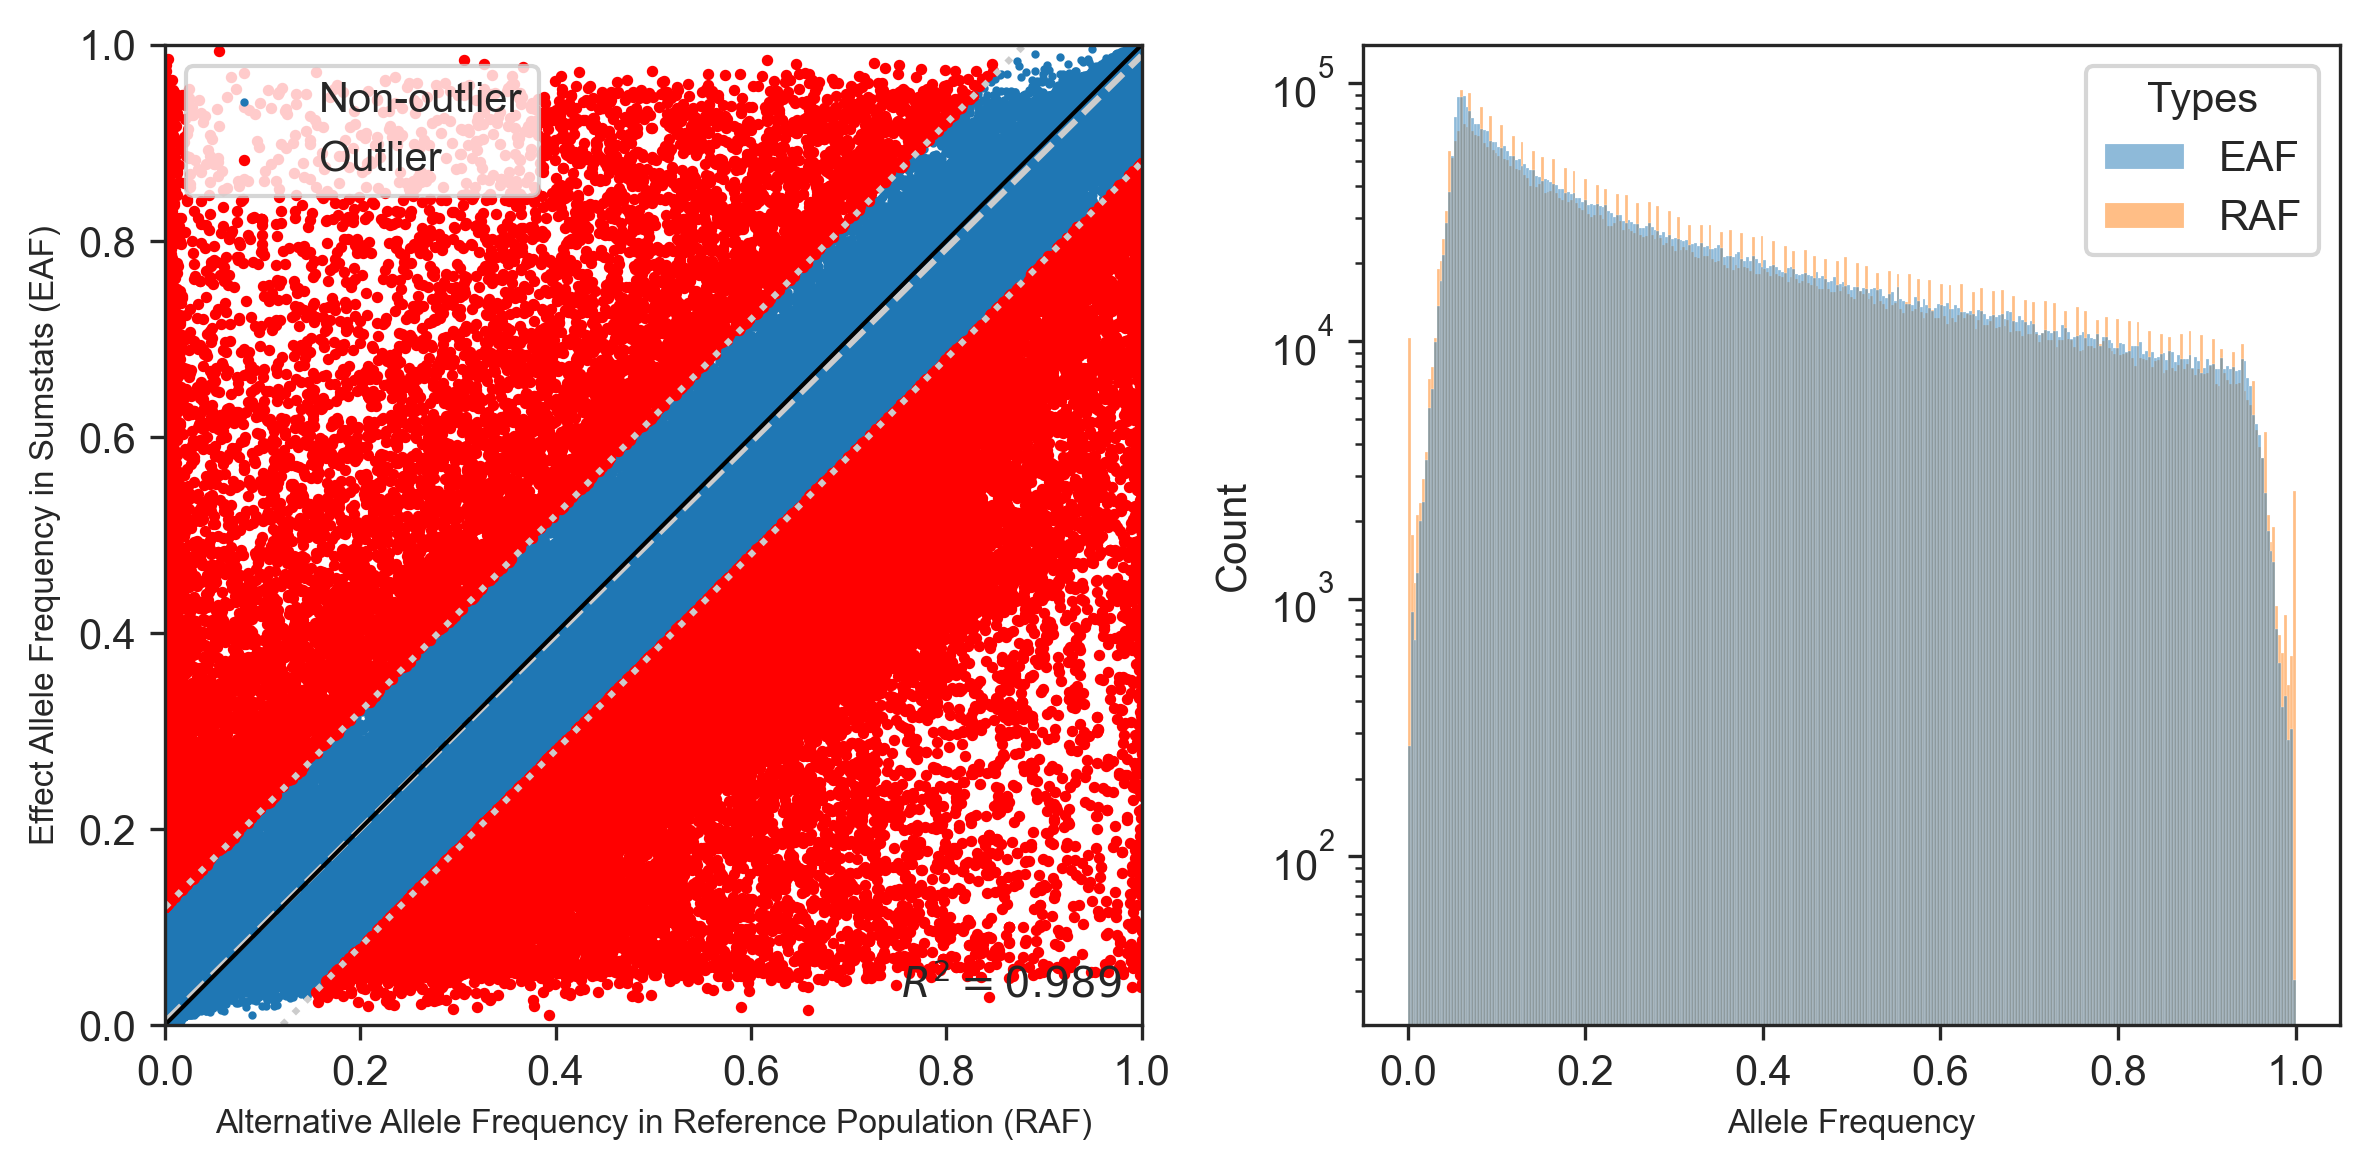

In [181]:
# gwas_women_sumstats_sample.plot_daf(threshold=0.12)
gwas_women_sumstats.plot_daf(threshold=0.12)

In [164]:
# gwas_men_sumstats_sample.check_af(
#     ref_infer=gl.get_path("1kg_eur_hg19"),
#     ref_alt_freq="AF",
#     n_cores=8,
# )

gwas_men_sumstats.check_af(
    ref_infer=gl.get_path("1kg_eur_hg19"),
    ref_alt_freq="AF",
    n_cores=8,
)

Mon Sep 18 14:32:15 2023 Start to check the difference between EAF and refence vcf alt frequency ...
Mon Sep 18 14:32:15 2023  -Current Dataframe shape : 6750240  x  14
Mon Sep 18 14:32:15 2023  -Reference vcf file: /Users/slaan3/.gwaslab/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz
Mon Sep 18 14:32:15 2023  -CPU Cores to use : 8
Mon Sep 18 14:32:15 2023  -Checking prefix for chromosomes in vcf files...
Mon Sep 18 14:32:15 2023  -No prefix for chromosomes in the VCF files.
Mon Sep 18 14:32:15 2023  -Alternative allele frequency in INFO: AF
Mon Sep 18 14:32:19 2023  -Checking variants: 6750240
Mon Sep 18 14:48:59 2023  - DAF min: 0.9837729930877686
Mon Sep 18 14:48:59 2023  - DAF max: -0.9631859660148621
Mon Sep 18 14:48:59 2023  - DAF sd: 0.03655026584475846
Mon Sep 18 14:48:59 2023  - abs(DAF) min: 0.0
Mon Sep 18 14:48:59 2023  - abs(DAF) max: 0.9837729930877686
Mon Sep 18 14:48:59 2023  - abs(DAF) sd: 0.032806883876339385
Mon Sep 18 14:48:59 2023 Finished allele frequency checking!


Mon Sep 18 15:47:11 2023 Start to plot Reference frequency vs Effect allele frequency plot...
Mon Sep 18 15:47:15 2023  -Plotting valriants:6392541
Mon Sep 18 15:47:16 2023  -Plotting regression line...
Mon Sep 18 15:47:16 2023  -Beta =  0.9861643022803861
Mon Sep 18 15:47:16 2023  -Intercept =  0.0029832745881614997
Mon Sep 18 15:47:16 2023  -R2 =  0.9893253540921204
Mon Sep 18 15:47:16 2023  -Threshold : 0.12
Mon Sep 18 15:47:16 2023  -Variants with relatively large DAF :  61525
Mon Sep 18 15:47:16 2023  -Percentage for variants with relatively large DAF :  0.009624498302005416


/Users/slaan3/miniconda3/envs/gwaslab/lib/python3.8/site-packages/gwaslab/compare_af.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


Mon Sep 18 15:47:58 2023  -Skip saving figures!


(<Figure size 2400x1200 with 2 Axes>,
                SNPID       EAF       DAF   EA NEA       RAF
 38           1:89946  0.141935 -0.131425    T   A  0.273360
 40           1:91536  0.312644 -0.323539    T   G  0.636183
 41           1:91581  0.312327 -0.323856    A   G  0.636183
 42           1:92858  0.148030 -0.131294    T   G  0.279324
 60          1:255923  0.293401  0.164176  GTC   G  0.129225
 ...              ...       ...       ...  ...  ..       ...
 6750114  22:51181519  0.365750 -0.201844    G   A  0.567594
 6750115  22:51181563  0.270675 -0.396323    C   A  0.666998
 6750116  22:51181568  0.273738 -0.397236    G   A  0.670974
 6750118  22:51181620  0.160253 -0.447103    C   T  0.607356
 6750119  22:51181624  0.160252 -0.446110    C   T  0.606362
 
 [61525 rows x 6 columns])

/Users/slaan3/miniconda3/envs/gwaslab/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/slaan3/miniconda3/envs/gwaslab/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


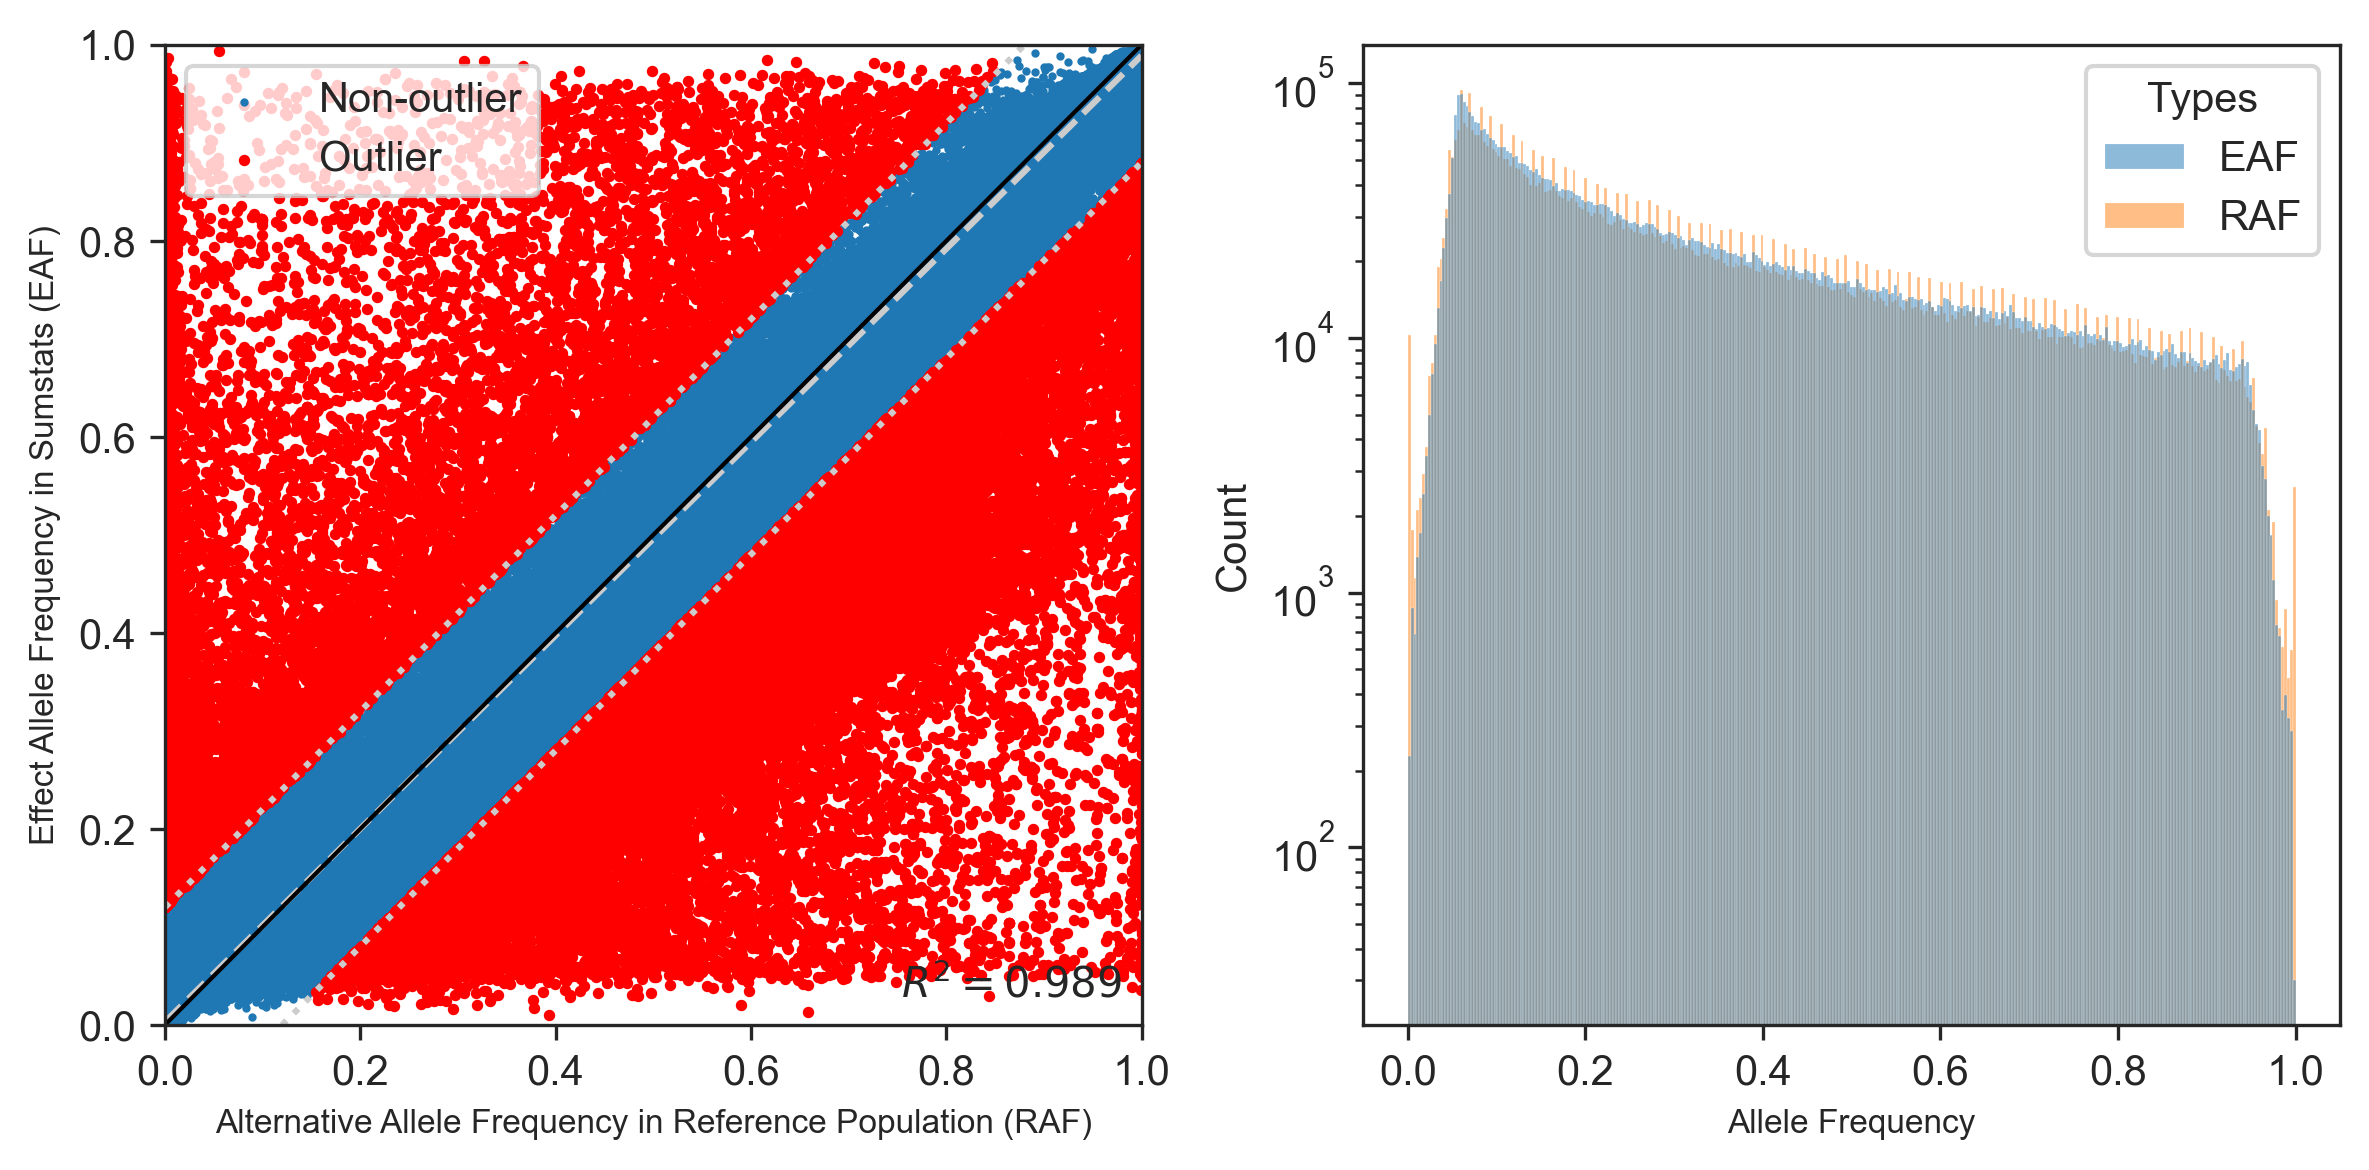

In [182]:
# gwas_men_sumstats_sample.plot_daf(threshold=0.12)
gwas_men_sumstats.plot_daf(threshold=0.12)

In [ ]:
del gwas_combo_sumstats_sample
del gwas_women_sumstats_sample
del gwas_men_sumstats_sample

##### Summary

So in summary we have done:
- a basic check, making sure the chr, pos, alleles are all in order
- multi-allelic, weird chromosomes, and duplicate variants are removed
- data are harmonized, such that the rsID is added, the alleles are relative to the references (and flipped if needed) 

> Note, while we do calculate the difference in allele frequencies between the datasets and the 1kG phase3 EUR reference, we **do not** filter on this for the purpose of sharing through _GWAS Catalog_. 
> Variants with relatively high DAF in the three datasets is less than 1%:
> - combo 61,353 variants of 6,750,240 in total
> - women 61,303 variants of 6,750,238 in total
> - men 61,525 variants of 6,750,240 in total

In [165]:
print("The parsed and harmonized SumStats object for combined:\n")

gwas_combo_sumstats.data

The parsed and harmonized SumStats object for combined:



,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID,rsID,DAF
0,1:10583,1,10583,A,G,0.149751,0.658801,0.423637,0.12,0.301118,12145,1980019,rs58108140,rs58108140,NaN
1,1:13302,1,13302,T,C,0.093359,0.139703,0.509556,0.78,0.332755,12145,1980019,rs180734498,rs75241669,NaN
2,1:30923,1,30923,T,G,0.834095,-0.317905,0.403550,0.43,0.330267,12145,1980019,rs140337953,rs806731,-0.102287
3,1:51479,1,51479,A,T,0.180721,0.199339,0.383897,0.60,0.318227,12145,1980019,rs116400033,rs116400033,-0.078722
4,1:54490,1,54490,A,G,0.176649,0.035508,0.383277,0.93,0.322577,12145,1980019,rs141149254,rs141149254,-0.004266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6750235,22:51229855,22,51229855,A,G,0.146274,0.027140,0.294785,0.93,0.641013,12145,1980019,rs144549712,rs144549712,-0.016748
6750236,22:51233300,22,51233300,T,C,0.335996,-0.239342,0.212296,0.26,0.695615,12145,1980019,rs62240042,rs9616839,0.032815
6750237,22:51236013,22,51236013,AT,A,0.239100,0.158471,0.241385,0.51,0.668405,12145,1980364,rs200507571,rs200507571,-0.028296
6750238,22:51237063,22,51237063,C,T,0.276894,-0.277995,0.224458,0.22,0.696999,12145,1980019,rs3896457,rs3896457,0.006516


In [166]:
print("The parsed and harmonized SumStats object for European-only:\n")

gwas_women_sumstats.data

The parsed and harmonized SumStats object for European-only:



,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID,rsID,DAF
0,1:10583,1,10583,A,G,0.151617,0.824988,0.659326,0.21,0.301118,5344,1980019,rs58108140,rs58108140,NaN
1,1:13302,1,13302,T,C,0.092958,0.659718,0.806601,0.41,0.332755,5344,1980019,rs180734498,rs75241669,NaN
2,1:30923,1,30923,T,G,0.833661,-0.782017,0.644221,0.22,0.330267,5344,1980019,rs140337953,rs806731,-0.102721
3,1:51479,1,51479,A,T,0.183391,0.173976,0.602009,0.77,0.318227,5344,1980019,rs116400033,rs116400033,-0.076052
4,1:54490,1,54490,A,G,0.179023,-0.308928,0.603387,0.61,0.322577,5344,1980019,rs141149254,rs141149254,-0.001892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6750233,22:51229855,22,51229855,A,G,0.148172,-0.390056,0.459037,0.40,0.641013,5344,1980019,rs144549712,rs144549712,-0.014850
6750234,22:51233300,22,51233300,T,C,0.339706,-0.058844,0.336962,0.86,0.695615,5344,1980019,rs62240042,rs9616839,0.036525
6750235,22:51236013,22,51236013,AT,A,0.236717,0.188759,0.383556,0.62,0.668405,5344,1980364,rs200507571,rs200507571,-0.030679
6750236,22:51237063,22,51237063,C,T,0.278372,-0.374821,0.356019,0.29,0.696999,5344,1980019,rs3896457,rs3896457,0.007994


In [167]:
print("The parsed and harmonized SumStats object for African-American-only:\n")

gwas_men_sumstats.data

The parsed and harmonized SumStats object for African-American-only:



,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID,rsID,DAF
0,1:10583,1,10583,A,G,0.148284,0.519809,0.549089,0.34,0.301118,6801,1980019,rs58108140,rs58108140,NaN
1,1:13302,1,13302,T,C,0.093675,-0.271376,0.651686,0.68,0.332755,6801,1980019,rs180734498,rs75241669,NaN
2,1:30923,1,30923,T,G,0.834437,0.002467,0.513017,1.00,0.330267,6801,1980019,rs140337953,rs806731,-0.101945
3,1:51479,1,51479,A,T,0.178622,0.265338,0.494794,0.59,0.318227,6801,1980019,rs116400033,rs116400033,-0.080821
4,1:54490,1,54490,A,G,0.174784,0.371793,0.492553,0.45,0.322577,6801,1980019,rs141149254,rs141149254,-0.006131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6750235,22:51229855,22,51229855,A,G,0.144783,0.274366,0.381691,0.47,0.641013,6801,1980019,rs144549712,rs144549712,-0.018239
6750236,22:51233300,22,51233300,T,C,0.333080,-0.398509,0.270816,0.14,0.695615,6801,1980019,rs62240042,rs9616839,0.029899
6750237,22:51236013,22,51236013,AT,A,0.240971,0.175344,0.307649,0.57,0.668405,6801,1980364,rs200507571,rs200507571,-0.026425
6750238,22:51237063,22,51237063,C,T,0.275733,-0.245600,0.286446,0.39,0.696999,6801,1980019,rs3896457,rs3896457,0.005355


#### Save or open data
Let's save (or open) the summary statistics object for future reference.

In [184]:
import gwaslab as gl

gl.dump_pickle(
    gwas_combo_sumstats,
    os.path.join(GWAS_RES_loc, "discovery_group/AOO_COMBINED_b37.gwaslab.pkl"),
    overwrite=True,
)

# gwas_combo_sumstats = gl.load_pickle(
#     os.path.join(
#         GWAS_RES_loc, "discovery_group/AOO_COMBINED_b37.gwaslab.pkl"
#     )
# )

Mon Sep 18 15:52:23 2023 Start to dump the Sumstats Object.
Mon Sep 18 15:52:23 2023  -Dump the Sumstats Object to :  /Users/slaan3/PLINK/_GWAS_Datasets/_SiGN/discovery_group/AOO_COMBINED_b37.gwaslab.pkl
Mon Sep 18 15:52:42 2023 Finished dumping.


In [185]:
import gwaslab as gl

gl.dump_pickle(
    gwas_women_sumstats,
    os.path.join(GWAS_RES_loc, "discovery_xx.group/AOO_WOMEN_b37.gwaslab.pkl"),
    overwrite=True,
)

# gwas_women_sumstats = gl.load_pickle(
#     os.path.join(GWAS_RES_loc, "discovery_xx.group/AOO_WOMEN_b37.gwaslab.pkl")
# )

Mon Sep 18 15:52:42 2023 Start to dump the Sumstats Object.
Mon Sep 18 15:52:42 2023  -Dump the Sumstats Object to :  /Users/slaan3/PLINK/_GWAS_Datasets/_SiGN/discovery_xx.group/AOO_WOMEN_b37.gwaslab.pkl
Mon Sep 18 15:52:55 2023 Finished dumping.


In [186]:
import gwaslab as gl

gl.dump_pickle(
    gwas_men_sumstats,
    os.path.join(GWAS_RES_loc, "discovery_xy.group/AOO_MEN_b37.gwaslab.pkl"),
    overwrite=True,
)

# gwas_men_sumstats = gl.load_pickle(
#     os.path.join(GWAS_RES_loc, "discovery_xy.group/AOO_MEN_b37.gwaslab.pkl")
# )

Mon Sep 18 15:52:55 2023 Start to dump the Sumstats Object.
Mon Sep 18 15:52:55 2023  -Dump the Sumstats Object to :  /Users/slaan3/PLINK/_GWAS_Datasets/_SiGN/discovery_xy.group/AOO_MEN_b37.gwaslab.pkl
Mon Sep 18 15:53:05 2023 Finished dumping.


In [187]:
import gwaslab as gl

gwas_combo_sumstats.log.show()

gwas_combo_sumstats.log.save(
    os.path.join(GWAS_RES_loc, "discovery_group/AOO_COMBINED_b37.gwaslab.log")
)

Sun Sep 17 12:31:11 2023 Sumstats Object created.
Sun Sep 17 12:31:11 2023 GWASLab v3.4.25 https://cloufield.github.io/gwaslab/
Sun Sep 17 12:31:11 2023 (C) 2022-2023, Yunye He, Kamatani Lab, MIT License, gwaslab@gmail.com
Sun Sep 17 12:31:11 2023 Start to initiate from pandas DataFrame ...
Sun Sep 17 12:31:17 2023  -Reading columns          : A1FREQ,BETA,N,CHRBPID,INFO,ALLELE0,VariantID,P_BOLT_LMM_INF,SE,BP,CHR,ALLELE1
Sun Sep 17 12:31:17 2023  -Renaming columns to      : EAF,BETA,N,SNPID,INFO,NEA,VariantID,P,SE,POS,CHR,EA
Sun Sep 17 12:31:17 2023  -Current Dataframe shape : 6750263  x  12
Sun Sep 17 12:31:20 2023  -Initiating a status column: STATUS ...
Sun Sep 17 12:31:23 2023 Start to reorder the columns...
Sun Sep 17 12:31:23 2023  -Current Dataframe shape : 6750263  x  13
Sun Sep 17 12:31:23 2023  -Reordering columns to    : SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID
Sun Sep 17 12:31:23 2023 Finished sorting columns successfully!
Sun Sep 17 12:31:24 2023  -Column:

In [188]:
import gwaslab as gl

gwas_women_sumstats.log.show()

gwas_women_sumstats.log.save(
    os.path.join(GWAS_RES_loc, "discovery_xx.group/AOO_WOMEN_b37.gwaslab.log")
)

Sun Sep 17 12:31:24 2023 Sumstats Object created.
Sun Sep 17 12:31:24 2023 GWASLab v3.4.25 https://cloufield.github.io/gwaslab/
Sun Sep 17 12:31:24 2023 (C) 2022-2023, Yunye He, Kamatani Lab, MIT License, gwaslab@gmail.com
Sun Sep 17 12:31:24 2023 Start to initiate from pandas DataFrame ...
Sun Sep 17 12:31:29 2023  -Reading columns          : A1FREQ,BETA,N,CHRBPID,INFO,ALLELE0,VariantID,P_BOLT_LMM_INF,SE,BP,CHR,ALLELE1
Sun Sep 17 12:31:29 2023  -Renaming columns to      : EAF,BETA,N,SNPID,INFO,NEA,VariantID,P,SE,POS,CHR,EA
Sun Sep 17 12:31:29 2023  -Current Dataframe shape : 6750263  x  12
Sun Sep 17 12:31:31 2023  -Initiating a status column: STATUS ...
Sun Sep 17 12:31:33 2023 Start to reorder the columns...
Sun Sep 17 12:31:33 2023  -Current Dataframe shape : 6750263  x  13
Sun Sep 17 12:31:33 2023  -Reordering columns to    : SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID
Sun Sep 17 12:31:33 2023 Finished sorting columns successfully!
Sun Sep 17 12:31:33 2023  -Column:

In [189]:
import gwaslab as gl

gwas_men_sumstats.log.show()

gwas_men_sumstats.log.save(
    os.path.join(GWAS_RES_loc, "discovery_xy.group/AOO_MEN_b37.gwaslab.log")
)

Sun Sep 17 12:31:36 2023 Sumstats Object created.
Sun Sep 17 12:31:36 2023 GWASLab v3.4.25 https://cloufield.github.io/gwaslab/
Sun Sep 17 12:31:36 2023 (C) 2022-2023, Yunye He, Kamatani Lab, MIT License, gwaslab@gmail.com
Sun Sep 17 12:31:36 2023 Start to initiate from pandas DataFrame ...
Sun Sep 17 12:31:41 2023  -Reading columns          : A1FREQ,BETA,N,CHRBPID,INFO,ALLELE0,VariantID,P_BOLT_LMM_INF,SE,BP,CHR,ALLELE1
Sun Sep 17 12:31:41 2023  -Renaming columns to      : EAF,BETA,N,SNPID,INFO,NEA,VariantID,P,SE,POS,CHR,EA
Sun Sep 17 12:31:41 2023  -Current Dataframe shape : 6750263  x  12
Sun Sep 17 12:31:43 2023  -Initiating a status column: STATUS ...
Sun Sep 17 12:31:45 2023 Start to reorder the columns...
Sun Sep 17 12:31:45 2023  -Current Dataframe shape : 6750263  x  13
Sun Sep 17 12:31:45 2023  -Reordering columns to    : SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID
Sun Sep 17 12:31:46 2023 Finished sorting columns successfully!
Sun Sep 17 12:31:46 2023  -Column:

##### Parquet

Save it as a parquet for easy loading as a dataframe in other programs (_e.g._ `R`).

In [190]:
import pyarrow as pa
import pyarrow.parquet as pq

# Convert DataFrame to Apache Arrow Table
temp_table = pa.Table.from_pandas(gwas_combo_sumstats.data)

# Parquet with Brotli compression
pq.write_table(
    temp_table,
    os.path.join(
        GWAS_RES_loc, "discovery_group/AOO_COMBINED_b37.gwaslab.parquet"),
    compression="BROTLI",
)
# we delete the temporary table object
del temp_table

In [191]:
import pyarrow as pa
import pyarrow.parquet as pq

# Convert DataFrame to Apache Arrow Table
temp_table = pa.Table.from_pandas(gwas_women_sumstats.data)

# Parquet with Brotli compression
pq.write_table(
    temp_table,
    os.path.join(
        GWAS_RES_loc, "discovery_xx.group/AOO_WOMEN_b37.gwaslab.parquet"),
    compression="BROTLI",
)
# we delete the temporary table object
del temp_table

In [192]:
import pyarrow as pa
import pyarrow.parquet as pq

# Convert DataFrame to Apache Arrow Table
temp_table = pa.Table.from_pandas(gwas_men_sumstats.data)

# Parquet with Brotli compression
pq.write_table(
    temp_table,
    os.path.join(
        GWAS_RES_loc, "discovery_xy.group/AOO_MEN_b37.gwaslab.parquet"),
    compression="BROTLI",
)
# we delete the temporary table object
del temp_table

##### GWAS Catalog

Save it in `GWAS catalog`-format

In [177]:
gwas_combo_sumstats.to_format(
    os.path.join(GWASCatalog_loc, "AOO_COMBINED_b37.gwaslab"),
    fmt="ssf",
    build="19",
)

Mon Sep 18 15:25:18 2023 Start to format the output sumstats in:  ssf  format
Mon Sep 18 15:25:21 2023  -Formatting statistics ...
Mon Sep 18 15:25:39 2023  - Float statistics formats:
Mon Sep 18 15:25:39 2023   - Columns: ['EAF', 'BETA', 'SE', 'INFO', 'P', 'DAF']
Mon Sep 18 15:25:39 2023   - Output formats: ['{:.4g}', '{:.4f}', '{:.4f}', '{:.4f}', '{:.4e}', '{:.4f}']
Mon Sep 18 15:25:39 2023  - Replacing SNPID separator from ":" to "_"...
Mon Sep 18 15:25:43 2023  - Start outputting sumstats in ssf format...
Mon Sep 18 15:25:46 2023  -ssf format will be loaded...
Mon Sep 18 15:25:46 2023  -ssf format meta info:
Mon Sep 18 15:25:46 2023   - format_name  : ssf
Mon Sep 18 15:25:46 2023   - format_source  : https://www.biorxiv.org/content/10.1101/2022.07.15.500230v1.full
Mon Sep 18 15:25:46 2023   - format_cite_name  : GWAS-SSF v0.1
Mon Sep 18 15:25:46 2023   - format_separator  : \t
Mon Sep 18 15:25:46 2023   - format_na  : #NA
Mon Sep 18 15:25:46 2023   - format_col_order  : chromosome,

In [178]:
gwas_women_sumstats.to_format(
    os.path.join(GWASCatalog_loc, "AOO_WOMEN_b37.gwaslab"),
    fmt="ssf",
    build="19",
)

Mon Sep 18 15:27:35 2023 Start to format the output sumstats in:  ssf  format
Mon Sep 18 15:27:39 2023  -Formatting statistics ...
Mon Sep 18 15:27:52 2023  - Float statistics formats:
Mon Sep 18 15:27:52 2023   - Columns: ['EAF', 'BETA', 'SE', 'INFO', 'P', 'DAF']
Mon Sep 18 15:27:52 2023   - Output formats: ['{:.4g}', '{:.4f}', '{:.4f}', '{:.4f}', '{:.4e}', '{:.4f}']
Mon Sep 18 15:27:52 2023  - Replacing SNPID separator from ":" to "_"...
Mon Sep 18 15:27:55 2023  - Start outputting sumstats in ssf format...
Mon Sep 18 15:27:58 2023  -ssf format will be loaded...
Mon Sep 18 15:27:58 2023  -ssf format meta info:
Mon Sep 18 15:27:58 2023   - format_name  : ssf
Mon Sep 18 15:27:58 2023   - format_source  : https://www.biorxiv.org/content/10.1101/2022.07.15.500230v1.full
Mon Sep 18 15:27:58 2023   - format_cite_name  : GWAS-SSF v0.1
Mon Sep 18 15:27:58 2023   - format_separator  : \t
Mon Sep 18 15:27:58 2023   - format_na  : #NA
Mon Sep 18 15:27:58 2023   - format_col_order  : chromosome,

In [179]:
gwas_men_sumstats.to_format(
    os.path.join(GWASCatalog_loc, "AOO_MEN_b37.gwaslab"),
    fmt="ssf",
    build="19",
)

Mon Sep 18 15:29:40 2023 Start to format the output sumstats in:  ssf  format
Mon Sep 18 15:29:45 2023  -Formatting statistics ...
Mon Sep 18 15:29:59 2023  - Float statistics formats:
Mon Sep 18 15:29:59 2023   - Columns: ['EAF', 'BETA', 'SE', 'INFO', 'P', 'DAF']
Mon Sep 18 15:29:59 2023   - Output formats: ['{:.4g}', '{:.4f}', '{:.4f}', '{:.4f}', '{:.4e}', '{:.4f}']
Mon Sep 18 15:29:59 2023  - Replacing SNPID separator from ":" to "_"...
Mon Sep 18 15:30:01 2023  - Start outputting sumstats in ssf format...
Mon Sep 18 15:30:05 2023  -ssf format will be loaded...
Mon Sep 18 15:30:05 2023  -ssf format meta info:
Mon Sep 18 15:30:05 2023   - format_name  : ssf
Mon Sep 18 15:30:05 2023   - format_source  : https://www.biorxiv.org/content/10.1101/2022.07.15.500230v1.full
Mon Sep 18 15:30:05 2023   - format_cite_name  : GWAS-SSF v0.1
Mon Sep 18 15:30:05 2023   - format_separator  : \t
Mon Sep 18 15:30:05 2023   - format_na  : #NA
Mon Sep 18 15:30:05 2023   - format_col_order  : chromosome,

After this, we need to validate results for `GWAS Catalog`. For this purpose we created an environment based on python 3.9 and used `gwas-sumstats-tools` (https://github.com/EBISPOT/gwas-sumstats-tools). We remove any remaining variant with alleles formatted such that is unacceptable for `GWAS Catalog`.

### Visualisations

Here we attempt to create a genome-wide plot annotating significant genes.

#### Manhattan and stratified QQ plots

Here we create an automatically annotated Manhattan plot. Annotation is based on hg19 (GRCh37), ensembl 87 (https://ftp.ensembl.org/pub/grch37/release-109/gtf/homo_sapiens/).



#### Combined

Mon Sep 18 13:20:24 2023 Start to plot manhattan/qq plot with the following basic settings:
Mon Sep 18 13:20:24 2023  -Genomic coordinates version: 19...
Mon Sep 18 13:20:24 2023  -Genome-wide significance level is set to 5e-08 ...
Mon Sep 18 13:20:24 2023  -Raw input contains 6750240 variants...
Mon Sep 18 13:20:24 2023  -Plot layout mode is : mqq
Mon Sep 18 13:20:27 2023 Finished loading specified columns from the sumstats.
Mon Sep 18 13:20:27 2023 Start conversion and sanity check:
Mon Sep 18 13:20:27 2023  -Removed 0 variants with nan in CHR or POS column ...
Mon Sep 18 13:20:29 2023  -Removed 0 varaints with CHR <=0...
Mon Sep 18 13:20:29 2023  -Removed 0 variants with nan in EAF column ...
Mon Sep 18 13:20:29 2023  -Removed 0 variants with nan in P column ...
Mon Sep 18 13:20:29 2023  -Sanity check after conversion: 0 variants with P value outside of (0,1] will be removed...
Mon Sep 18 13:20:30 2023  -Sumstats P values are being converted to -log10(P)...
Mon Sep 18 13:20:30 2023 

(<Figure size 1080x360 with 2 Axes>, <gwaslab.Log.Log at 0x7fbf72425610>)

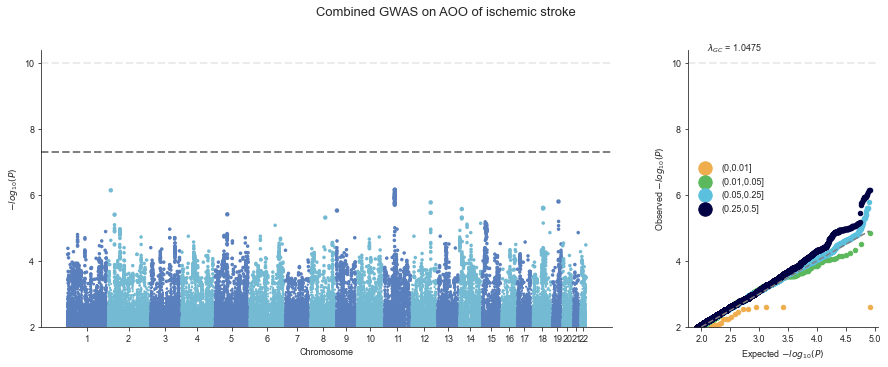

In [152]:
# manhattan and qq plot
gwas_combo_sumstats.plot_mqq(
    skip=2,
    cut=10,
    sig_line=True,
    sig_level=5e-8,
    anno="GENENAME",
    anno_style="right",
    windowsizekb=500,
    arm_offset=2,
    repel_force=0.02,  # default 0.01
    use_rank=True,
    build="19",
    # mode="m",
    stratified=True,
    drop_chr_start=True,
    # figargs={"figsize": (25, 15), "dpi": 300},
    title="Combined GWAS on AOO of ischemic stroke",
    save=os.path.join(PLOTS_loc, "manhattan.500kb.300dpi.COMBINED.pdf"),
    saveargs={"dpi": 300},
    verbose=True,
)

Let's create publication ready images for the Nature Genetics revision.

Mon Sep 18 13:20:37 2023 Start to plot manhattan/qq plot with the following basic settings:
Mon Sep 18 13:20:37 2023  -Genomic coordinates version: 19...
Mon Sep 18 13:20:37 2023  -Genome-wide significance level is set to 5e-08 ...
Mon Sep 18 13:20:37 2023  -Raw input contains 6750240 variants...
Mon Sep 18 13:20:37 2023  -Plot layout mode is : qq
Mon Sep 18 13:20:37 2023 Finished loading specified columns from the sumstats.
Mon Sep 18 13:20:37 2023 Start conversion and sanity check:
Mon Sep 18 13:20:37 2023  -Removed 0 variants with nan in P column ...
Mon Sep 18 13:20:38 2023  -Sanity check after conversion: 0 variants with P value outside of (0,1] will be removed...
Mon Sep 18 13:20:38 2023  -Sumstats P values are being converted to -log10(P)...
Mon Sep 18 13:20:38 2023  -Sanity check: 0 na/inf/-inf variants will be removed...
Mon Sep 18 13:20:39 2023  -Maximum -log10(P) values is 6.154901959985743 .
Mon Sep 18 13:20:39 2023 Finished data conversion and sanity check.
Mon Sep 18 13:2

(<Figure size 1080x360 with 1 Axes>, <gwaslab.Log.Log at 0x7fbf72425610>)

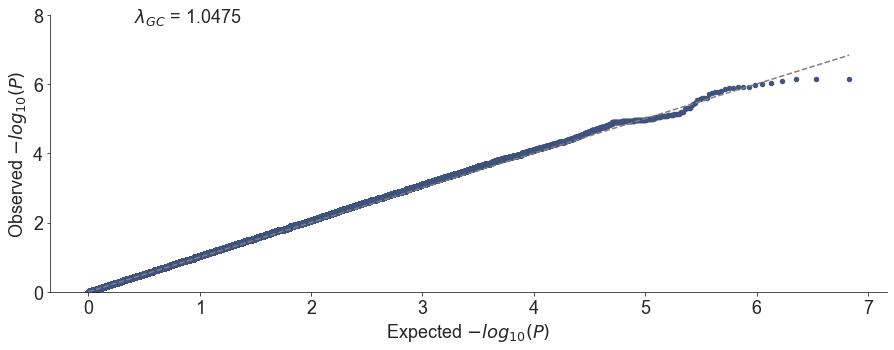

In [153]:
# qq plot
gwas_combo_sumstats.plot_mqq(
    build="19",
    mode="qq",  # only qq plot
    colors=["#3f517d", "#62acc2"],
    fontsize=18,
    # figargs={"figsize": (15, 15), "dpi": 300},
    save=os.path.join(PLOTS_loc, "qq_only.500kb.300dpi.COMBINED.pdf"),
    saveargs={"dpi": 300},
    verbose=True,
)

#### Women-only populations

Mon Sep 18 13:21:09 2023 Start to plot manhattan/qq plot with the following basic settings:
Mon Sep 18 13:21:09 2023  -Genomic coordinates version: 19...
Mon Sep 18 13:21:09 2023  -Genome-wide significance level is set to 5e-08 ...
Mon Sep 18 13:21:09 2023  -Raw input contains 6750238 variants...
Mon Sep 18 13:21:09 2023  -Plot layout mode is : mqq
Mon Sep 18 13:21:11 2023 Finished loading specified columns from the sumstats.
Mon Sep 18 13:21:11 2023 Start conversion and sanity check:
Mon Sep 18 13:21:11 2023  -Removed 0 variants with nan in CHR or POS column ...
Mon Sep 18 13:21:13 2023  -Removed 0 varaints with CHR <=0...
Mon Sep 18 13:21:13 2023  -Removed 0 variants with nan in EAF column ...
Mon Sep 18 13:21:13 2023  -Removed 0 variants with nan in P column ...
Mon Sep 18 13:21:13 2023  -Sanity check after conversion: 0 variants with P value outside of (0,1] will be removed...
Mon Sep 18 13:21:13 2023  -Sumstats P values are being converted to -log10(P)...
Mon Sep 18 13:21:14 2023 

(<Figure size 1080x360 with 2 Axes>, <gwaslab.Log.Log at 0x7fbf72425610>)

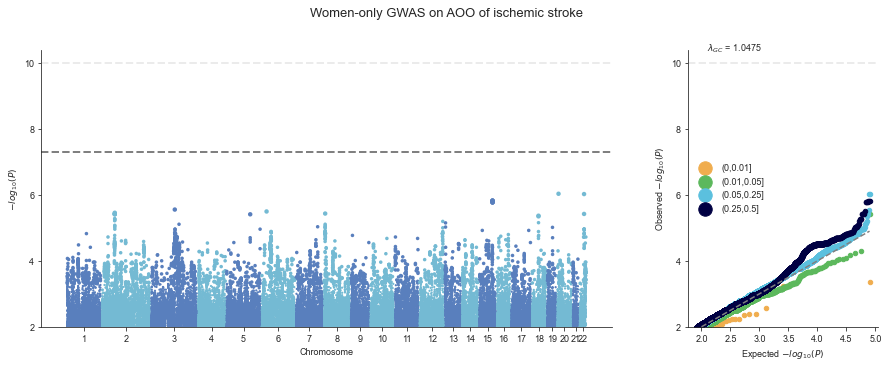

In [154]:
# manhattan and qq plot
gwas_women_sumstats.plot_mqq(
    skip=2,
    cut=10,
    sig_line=True,
    sig_level=5e-8,
    anno="GENENAME",
    anno_style="right",
    windowsizekb=500,
    arm_offset=2,
    repel_force=0.02,  # default 0.01
    use_rank=True,
    build="19",
    # mode="m",
    stratified=True,
    drop_chr_start=True,
    # figargs={"figsize": (25, 15), "dpi": 300},
    title="Women-only GWAS on AOO of ischemic stroke",
    save=os.path.join(PLOTS_loc, "manhattan.500kb.300dpi.WOMEN.pdf"),
    saveargs={"dpi": 300},
    verbose=True,
)

#### Men-only populations

Mon Sep 18 13:21:20 2023 Start to plot manhattan/qq plot with the following basic settings:
Mon Sep 18 13:21:20 2023  -Genomic coordinates version: 19...
Mon Sep 18 13:21:20 2023  -Genome-wide significance level is set to 5e-08 ...
Mon Sep 18 13:21:20 2023  -Raw input contains 6750240 variants...
Mon Sep 18 13:21:20 2023  -Plot layout mode is : mqq
Mon Sep 18 13:21:21 2023 Finished loading specified columns from the sumstats.
Mon Sep 18 13:21:21 2023 Start conversion and sanity check:
Mon Sep 18 13:21:21 2023  -Removed 0 variants with nan in CHR or POS column ...
Mon Sep 18 13:21:23 2023  -Removed 0 varaints with CHR <=0...
Mon Sep 18 13:21:23 2023  -Removed 0 variants with nan in EAF column ...
Mon Sep 18 13:21:23 2023  -Removed 0 variants with nan in P column ...
Mon Sep 18 13:21:23 2023  -Sanity check after conversion: 0 variants with P value outside of (0,1] will be removed...
Mon Sep 18 13:21:24 2023  -Sumstats P values are being converted to -log10(P)...
Mon Sep 18 13:21:24 2023 

(<Figure size 1080x360 with 2 Axes>, <gwaslab.Log.Log at 0x7fbf72425610>)

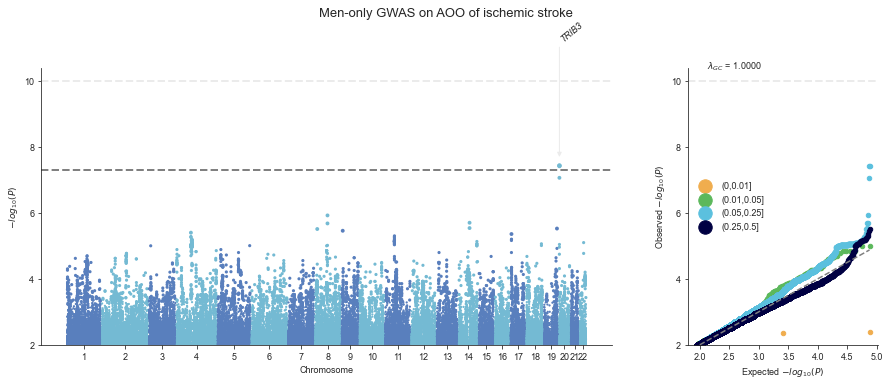

In [155]:
# manhattan and qq plot
gwas_men_sumstats.plot_mqq(
    skip=2,
    cut=10,
    sig_line=True,
    sig_level=5e-8,
    anno="GENENAME",
    anno_style="right",
    windowsizekb=500,
    arm_offset=2,
    repel_force=0.02,  # default 0.01
    use_rank=True,
    build="19",
    # mode="m",
    stratified=True,
    drop_chr_start=True,
    # figargs={"figsize": (25, 15), "dpi": 300},
    title="Men-only GWAS on AOO of ischemic stroke",
    save=os.path.join(PLOTS_loc, "manhattan.500kb.300dpi.MEN.pdf"),
    saveargs={"dpi": 300},
    verbose=True,
)

### Top loci

We inventory the top loci. 


In [156]:
gwas_combo_sumstats.get_lead(anno=True)

Mon Sep 18 13:21:30 2023 Start to extract lead variants...
Mon Sep 18 13:21:30 2023  -Processing 6750240 variants...
Mon Sep 18 13:21:30 2023  -Significance threshold : 5e-08
Mon Sep 18 13:21:30 2023  -Sliding window size: 500  kb
Mon Sep 18 13:21:37 2023  -Found 0 significant variants in total...
Mon Sep 18 13:21:37 2023  -Identified 0 lead variants!
Mon Sep 18 13:21:37 2023 Finished extracting lead variants successfully!


,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID,rsID


In [157]:
gwas_women_sumstats.get_lead(anno=True)

Mon Sep 18 13:21:39 2023 Start to extract lead variants...
Mon Sep 18 13:21:39 2023  -Processing 6750238 variants...
Mon Sep 18 13:21:39 2023  -Significance threshold : 5e-08
Mon Sep 18 13:21:39 2023  -Sliding window size: 500  kb
Mon Sep 18 13:21:44 2023  -Found 0 significant variants in total...
Mon Sep 18 13:21:44 2023  -Identified 0 lead variants!
Mon Sep 18 13:21:44 2023 Finished extracting lead variants successfully!


,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID,rsID


In [158]:
gwas_men_sumstats.get_lead(anno=True)

Mon Sep 18 13:21:45 2023 Start to extract lead variants...
Mon Sep 18 13:21:45 2023  -Processing 6750240 variants...
Mon Sep 18 13:21:45 2023  -Significance threshold : 5e-08
Mon Sep 18 13:21:45 2023  -Sliding window size: 500  kb
Mon Sep 18 13:21:51 2023  -Found 2 significant variants in total...
Mon Sep 18 13:21:51 2023  -Identified 1 lead variants!
Mon Sep 18 13:21:51 2023  -Annotating variants using references:ensembl
Mon Sep 18 13:21:51 2023  -Annotating variants using references based on genome build:19
Mon Sep 18 13:21:51 2023 Start to annotate variants with nearest gene name(s)...
Mon Sep 18 13:21:51 2023  -Assigning Gene name using ensembl_hg19_gtf for protein coding genes
Mon Sep 18 13:21:51 2023 Finished annotating variants with nearest gene name(s) successfully!
Mon Sep 18 13:21:51 2023 Finished extracting lead variants successfully!


,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID,rsID,LOCATION,GENE
6408548,20:374763,20,374763,T,C,0.13519,-1.94908,0.354032,3.700000e-08,0.830396,6801,1980019,rs6051656,rs6051656,0,TRIB3


Mon Sep 18 13:21:52 2023 Start to plot miami plot with the following basic settings:
Mon Sep 18 13:21:52 2023  -Genome-wide significance level is set to 5e-08 ...
Mon Sep 18 13:21:52 2023  -Loci to highlight :  [] [(20, 374763)] []
Mon Sep 18 13:21:52 2023  -Highlight_window is set to:  500  kb
Mon Sep 18 13:21:52 2023  -Sumstats1 CHR,POS,P information will be obtained from: ['CHR', 'POS', 'P']
Mon Sep 18 13:21:52 2023  -Loading sumstats1 from gwaslab.Sumstats Object
Mon Sep 18 13:21:52 2023  -Sumstats2 CHR,POS,P information will be obtained from: ['CHR', 'POS', 'P']
Mon Sep 18 13:21:52 2023  -Loading sumstats2 from gwaslab.Sumstats Object
Mon Sep 18 13:21:52 2023  -Sanity check after conversion: 0 variants with P value outside of (0,1] will be removed...
Mon Sep 18 13:21:53 2023  -Sumstats P values are being converted to -log10(P)...
Mon Sep 18 13:21:53 2023  -Sanity check: 0 na/inf/-inf variants will be removed...
Mon Sep 18 13:21:54 2023  -Sanity check after conversion: 0 variants w

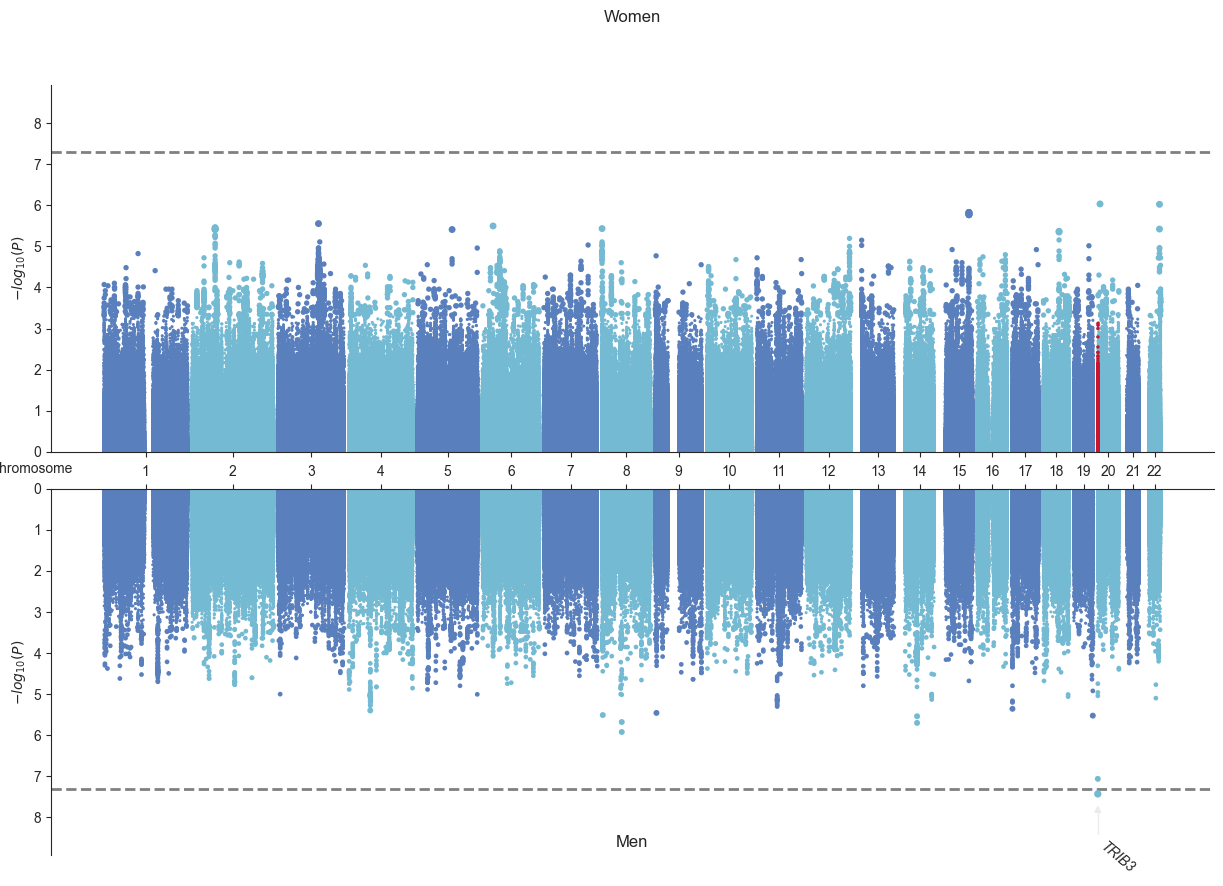

In [159]:
sumstats_miami = gl.plot_miami(
    path1=gwas_women_sumstats,
    path2=gwas_men_sumstats,
    cols1=["CHR", "POS", "P"],
    cols2=["CHR", "POS", "P"],
    titles=["Women", "Men"],
    titles_pad=[0.15, 0.0],
    anno="GENENAME",
    region_grid=True,
    highlight1=[(20, 374763)],  # TRIB3
    # pinpoint2=[(2,653874)]
)